## Blosum strategies
* This file compares using the original blosum rows as features vs. doing eigenvalue decomposition and then constructing features

In [1]:
import os, sys
import numpy as np
import json
import random
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import linalg as LA

## Preliminary

In [2]:
torch.manual_seed(12345)
k = 10000
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids

NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*12 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue

aa_dict = dict(zip(aa_list, pvals))
encoding_style = 'clipped'
lambda_val = 3

In [3]:
# New distribution (not NNK exactly)
#aa_list = ["A", "C", "D", "E", "F", "G", "H",  "I",  "K",  "L",  "M",  "N", "P", "Q", "R", "S", "T", "V",  "W", "Y"]
#pvals = [0.07593866356305902, 0.03631684619058439, 0.024513616151124667, 0.041131394815058675, 0.023547479168888497, 0.13123048459865624, 0.01854949620472682, 0.02172407877104557, 0.030274641454491498, 0.08833837978698246, 0.03053708795667314, 0.01740975503447508, 0.03779878792375141, 0.02613447832961611, 0.12025187445227044, 0.07884449349216138, 0.03949105780778344, 0.0859082921038843, 0.05098231963758271, 0.021076772557184122]
#aa_dict = dict(zip(aa_list, pvals))

In [4]:
# Original BLOSUM62 matrix
original_blosum62 = {}
with open('blosum62.txt', 'r') as f:
    for line in f:
        split_line = line.strip().split()
        aa = split_line[0]
        encoding = [int(x) for x in split_line[1:-3]]
        original_blosum62[aa] = encoding

In [5]:
blosum_matrix = np.zeros((20, 20))
for i, aa in enumerate(original_blosum62.keys()):
    sims = original_blosum62[aa]
    for j, s in enumerate(sims):
        blosum_matrix[i][j] = s   
u, V = LA.eig(blosum_matrix)
clipped_u = u
clipped_u[clipped_u < 0] = 0
lamb = np.diag(clipped_u)
T = V
clip_blosum62 = {}
for i, aa in enumerate(original_blosum62.keys()):
    clip_blosum62[aa] = np.dot(np.sqrt(lamb), V[i])

## Dataset

In [6]:
class BinaryDataset(Dataset):
    def __init__(self, filepath):
        def construct_binary_dataset(filepath):
            with open(filepath, 'r') as f:
                aptamer_data = json.load(f)
            ds = []
            for aptamer in aptamer_data:
                peptides = aptamer_data[aptamer]
                for peptide in peptides:
                    ds.append((aptamer, peptide, 1))
                    ds.append((get_x(), get_y(), 0))
            ds = list(set(ds)) #removed duplicates, random order
            return ds

        # Sample x from P_X (assume apatamers follow uniform)
        def get_x():
            x_idx = np.random.randint(0, 4, 40)
            x = ""
            for i in x_idx:
                x += na_list[i]
            return x

        # Sample y from P_y (assume peptides follow NNK)
        def get_y():
            y_idx = np.random.choice(20, 7, p=pvals)
            y = "M"
            for i in y_idx:
                y += aa_list[i]
            return y

        self.binary_ds=construct_binary_dataset(filepath)

    def __len__(self):
        return len(self.binary_ds)

    def __getitem__(self,idx):
        return(self.binary_ds[idx])

In [7]:
class EvalDataset(Dataset):
    def __init__(self, filepath):
        def construct_binary_dataset(filepath):
            with open(filepath, 'r') as f:
                aptamer_data = json.load(f)
            ds = []
            for aptamer in aptamer_data:
                peptides = aptamer_data[aptamer]
                for peptide in peptides:
                    ds.append((aptamer, peptide, 1))
            ds = list(set(ds)) #removed duplicates, random order
            return ds

        self.binary_ds=construct_binary_dataset(filepath)

    def __len__(self):
        return len(self.binary_ds)

    def __getitem__(self,idx):
        return(self.binary_ds[idx])

In [8]:
class HalfDataset(Dataset):
    def __init__(self, filepath):
        def construct_half_dataset(filepath):
            with open(filepath, 'r') as f:
                aptamer_data = json.load(f)
            ds = []
            for aptamer in aptamer_data:
                peptides = aptamer_data[aptamer]
                for peptide in peptides:
                    ds.append((get_x(), peptide, 0))
            ds = list(set(ds)) #removed duplicates, random order
            return ds

        # Sample x from P_X (assume apatamers follow uniform)
        def get_x():
            x_idx = np.random.randint(0, 4, 40)
            x = ""
            for i in x_idx:
                x += na_list[i]
            return x
        
         # Sample y from P_y (assume peptides follow NNK)
        def get_y():
            y_idx = np.random.choice(20, 7, p=pvals)
            y = "M"
            for i in y_idx:
                y += aa_list[i]
            return y

        self.binary_ds=construct_half_dataset(filepath)

    def __len__(self):
        return len(self.binary_ds)

    def __getitem__(self,idx):
        return(self.binary_ds[idx])

In [9]:
class GeneratedDataset(Dataset):
    def __init__(self, n):
        def construct_generated_dataset(k):
            S_new = []
            for _, i in enumerate(tqdm.tqdm(range(k))):
                pair = (get_x(), get_y())
                S_new.append(pair)
            np.random.shuffle(S_new)
            return S_new
        
        # Sample x from P_X (assume apatamers follow uniform)
        def get_x():
            x_idx = np.random.randint(0, 4, 40)
            x = ""
            for i in x_idx:
                x += na_list[i]
            return x

        # Sample y from P_y (assume peptides follow NNK)
        def get_y():
            y_idx = np.random.choice(20, 7, p=pvals)
            y = "M"
            for i in y_idx:
                y += aa_list[i]
            return y
        self.gen_ds = construct_generated_dataset(n)
    def __len__(self):
        return len(self.gen_ds)
    
    def __getitem__(self, idx):
        return (self.gen_ds[idx])

In [10]:
binary_ds=BinaryDataset(filepath="../data/higher_quality_data.json")
n = len(binary_ds)
m = int(0.8*n) #length of train
binary_train = binary_ds[:m]
binary_val = binary_ds[m:]
#eval_ds = EvalDataset(filepath="../data/no_peptide_data.json")

half_ds = HalfDataset(filepath="../data/aptamer_dataset.json")
len(half_ds)

## NN Model

In [11]:
# Expects peptides to be encoding according to BLOSUM62 matrix
# Expects aptamers to be one hot encoded
class BlosumNet(nn.Module):
    def __init__(self):
        super(BlosumNet, self).__init__()
        self.name = "BlosumNet"
        self.single_alphabet = False
        
        self.cnn_apt_1 = nn.Conv1d(4, 25, 3, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(25, 50, 3, padding=2) 
        self.cnn_apt_3 = nn.Conv1d(50, 25, 3, padding=2) 
        self.cnn_apt_4 = nn.Conv1d(25, 10, 3) 
        
        # There are 20 channels
        self.cnn_pep_1 = nn.Conv1d(20, 40, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(40, 80, 3, padding=2)
        self.cnn_pep_3 = nn.Conv1d(80, 150, 3, padding=2)
        self.cnn_pep_4 = nn.Conv1d(150, 50, 3, padding=2)
        self.cnn_pep_5 = nn.Conv1d(50, 10, 3, padding=2)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(790, 500)
        self.fc2 = nn.Linear(500, 200)
        self.fc3 = nn.Linear(200, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

In [12]:
# Expects peptides to be encoding according to BLOSUM62 matrix
# Expects aptamers to be one hot encoded
class BlosumLinearNet(nn.Module):
    def __init__(self):
        super(BlosumLinearNet, self).__init__()
        self.name = "BlosumLinearNet"
        self.single_alphabet = False
        
        self.fc_apt_1 = nn.Linear(160, 200) 
        self.fc_apt_2 = nn.Linear(200, 250)
        self.fc_apt_3 = nn.Linear(250, 300)
        
        self.fc_pep_1 = nn.Linear(160, 200)
        self.fc_pep_2 = nn.Linear(200, 250)
        
        self.relu = nn.ReLU()
        
        self.fc_apt = nn.Sequential(self.fc_apt_1, self.fc_apt_2, self.fc_apt_3)
        self.fc_pep = nn.Sequential(self.fc_pep_1, self.fc_pep_2)
        
        self.fc1 = nn.Linear(550, 600)
        self.fc2 = nn.Linear(600, 1)
        
    def forward(self, apt, pep):
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        apt = self.fc_apt(apt)
        pep = self.fc_pep(pep)
        x = torch.cat((apt, pep), 1)
        x = self.fc2(self.fc1(x))
        x = torch.sigmoid(x)
        return x

In [13]:
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

## Helper methods

In [14]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide', single_alphabet=False):
    if single_alphabet:
        apt = sequence[0]
        pep = sequence[1]
        one_hot = np.zeros((len(apt) + len(pep), 24))
        # Encode the aptamer first
        for i in range(len(apt)):
            char = apt[i]
            for _ in range(len(na_list)):
                idx = na_list.index(char)
                one_hot[i][idx] = 1
            
        # Encode the peptide second
        for i in range(len(pep)):
            char = pep[i]
            for _ in range(len(aa_list)):
                idx = aa_list.index(char) + len(na_list)
                one_hot[i+len(apt)][idx] = 1
        
        return one_hot       
    else:
        if seq_type == 'peptide':
            letters = aa_list
        else:
            letters = na_list
        one_hot = np.zeros((len(sequence), len(letters)))
        for i in range(len(sequence)):
            char = sequence[i]
            for _ in range(len(letters)):
                idx = letters.index(char)
                one_hot[i][idx] = 1
        return one_hot
    
## For aptamer sequence, translate
## For peptide sequence, translate and add additional biological properties
def extract_features(sequence, seq_type='peptide', single_alphabet=False):
    if single_alphabet:
        pass
    else:
        if seq_type == 'peptide':
            letters = aa_list
            encoding = np.zeros((4, len(sequence)))
            for i in range(len(sequence)):
                char = sequence[i]
                
                idx = letters.index(char)
                char_hydro = hydrophobicity[char]
                char_polar = polarity[char]
                char_vol = volume[char]
                char_charge = charge[char]
                
                # Put in the biological features of the amino acids
                encoding[0][i] = char_polar
                encoding[1][i] = char_vol
                encoding[2][i] = char_charge
                encoding[3][i] = char_hydro
        else:
            letters = na_list
            encoding = np.zeros(len(sequence))
            for i in range(len(sequence)):
                char = sequence[i]
                idx = letters.index(char)
                encoding[i] = idx
        return encoding 

def blosum62_encoding(sequence, seq_type='peptide', single_alphabet=False, style=encoding_style):
    if single_alphabet:
        pass
    else:
        if seq_type == 'peptide':
            encoding = []
            for i in range(len(sequence)):
                if style == "clipped":
                    encoding.append(clip_blosum62[sequence[i]])
                else:
                    encoding.append(original_blosum62[sequence[i]])
            encoding = np.asarray(encoding)
        else:
            #Translation
            letters = na_list
            encoding = np.zeros(len(sequence))
            for i in range(len(sequence)):
                char = sequence[i]
                idx = letters.index(char)
                encoding[i] = idx
        return encoding 

## Takes a peptide and aptamer sequence and converts to directly translated sequence
def translate(sequence, seq_type='peptide', single_alphabet=False):
    if single_alphabet:
        apt = sequence[0]
        pep = sequence[1]
        
        encoding = np.zeros(len(apt) + len(pep))
        
        # Encode the aptamer first
        for i in range(len(apt)):
            char = apt[i]
            idx = na_list.index(char)
            encoding[i] = idx
            
        # Encode the peptide second
        for i in range(len(pep)):
            char = pep[i]
            idx = aa_list.index(char)
            encoding[i+len(apt)] = idx
        return encoding     
    else:
        if seq_type == 'peptide':
            letters = aa_list
        else:
            letters = na_list
        
        encoding = np.zeros(len(sequence))
        for i in range(len(sequence)):
            char = sequence[i]
            idx = letters.index(char)
            encoding[i] = idx
        return encoding

# Convert a pair to one-hot tensor
def convert(apt, pep, label, single_alphabet=False): 
    if single_alphabet:
        pair = translate([apt, pep], single_alphabet=True) #(2, 40)
        pair = torch.FloatTensor(np.reshape(pair, (-1, pair.shape[0], pair.shape[1]))).to(device)
        label = torch.FloatTensor([[label]]).to(device)
        return pair, label
    else:
        apt = one_hot(apt, seq_type='aptamer') 
        pep = blosum62_encoding(pep, seq_type='peptide') 
        apt = torch.FloatTensor(np.reshape(apt, (-1, apt.shape[1], apt.shape[0]))).to(device) #(1, 1, 40)
        pep = torch.FloatTensor(np.reshape(pep, (-1, pep.shape[1], pep.shape[0]))).to(device) #(1, 1, 8)
        
        label = torch.FloatTensor([[label]]).to(device)
        return apt, pep, label

# Getting the output of the model for a pair (aptamer, peptide)
def update(x, y, p, single_alphabet=False):
    if single_alphabet:
        p.requires_grad=True
        p = p.to(device)
        out = model(p)
        return out
    else:
        x.requires_grad=True
        y.requires_grad=True
        x = x.to(device)
        y = y.to(device)
        out = model(x, y)
        return out

## Plotting functions
def plot_loss(iters, train_losses, val_losses, model_name, model_id):
    plt.title("Loss Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("%d Iterations" %iters)
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/%s/loss.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_accuracy(iters, train_acc, val_acc, model_name, model_id):
    plt.title("Training Accuracy Curve")
    plt.plot(train_acc, label="Train")
    plt.plot(val_acc, label="Validation")
    plt.xlabel("%d Iterations" %iters)
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/%s/accuracy.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_histogram(train_gen_scores, train_scores, val_gen_scores, val_scores, model_name, model_id):
    fig, ax = plt.subplots()
    plt.xlim(0, 1.1)
    
    sns.distplot(train_gen_scores , color="skyblue", label='Generated Train Samples', ax=ax)
    sns.distplot(val_gen_scores, color='dodgerblue', label='Generated Validation Samples')
    sns.distplot(train_scores , color="lightcoral", label='Dataset Train Samples', ax=ax)
    sns.distplot(val_scores, color='red', label='Dataset Validation Samples', ax=ax)
    
    ax.set_title("Categorizing the output scores of the model")
    ax.figure.set_size_inches(7, 4)
    ax.legend()
    plt.savefig('plots/binary/%s/%s/histogram.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_ecdf_test(test_score, iters, epoch, gamma, model_name, model_id):
    test_idx = np.argsort(test_score)
    test_id = test_idx >= 10000
    test = np.sort(test_score)
    test_c = ""
    for m in test_id:
        if m:
            test_c += "y"
        else:
            test_c += "g"
    n = test_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, test, c=test_c, label='Test CDF')
    plt.ylabel("CDF")
    plt.xlabel("Most recent 10,000 samples after training %d samples" %iters)
    plt.title('Test CDF at epoch %d' %epoch + ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/binary/%s/%s/test_cdf.png' %(model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_ecdf_train(train_score, iters, epoch, gamma, model_name, model_id):
    train_idx = np.argsort(train_score)
    train_id = train_idx >= 10000
    train = np.sort(train_score)
    train_c = "" #colors
    for l in train_id:
        if l:
            train_c += "r"
        else:
            train_c += "b"
    n = train_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, train, c=train_c, label='Train CDF')
    plt.ylabel("CDF")
    plt.xlabel("Most recent 10,000 samples after training %d samples" % iters)
    plt.title('Train CDF at epoch %d' %epoch+ ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/binary/%s/%s/train_cdf.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def auc_cdf(train, new, model_name, model_id, val=False): 
    #train is the sorted list of outputs from the model with training pairs as inputs
    #new is the list of outputs from the model with generated pairs as inputs
    a = train + new
    n = len(a)
    m = len(train)
    train = np.asarray(train)
    new = np.asarray(new)
    y = np.arange(0, m+2)/m
    gamma = [0]
    for x in train:
        gamma.append(sum(a<=x)/n)
    gamma.append(1)
    plt.plot(gamma, y)
    if val:
        plt.title("Validation CDF")
    else:
        plt.title("Train CDF")
    plt.xlim([0,1])
    if val:
        plt.savefig('plots/binary/%s/%s/val_cdf.png' % (model_name, model_id), bbox_inches='tight')
    else:
        plt.savefig('plots/binary/%s/%s/train_cdf.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()
    plt.close()
    return np.trapz(y, gamma)

## Binary Classification

In [15]:
if device == torch.cuda:
    torch.cuda.empty_cache()

In [16]:
def classifier(model, 
               train, 
               val,
               lr,
               model_id,
               num_epochs=50,
               batch_size=16,
               single_alphabet=False,
               run_from_checkpoint=None, 
               save_checkpoints=None,
               cdf=False):
    
    if run_from_checkpoint is not None:
        checkpointed_model = run_from_checkpoint
        checkpoint = torch.load(checkpointed_model)
        optimizer = SGD(model.parameters(), lr=lr)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        init_epoch = checkpoint['epoch'] +1
        print("Reloading model: ", model.name, " at epoch: ", init_epoch)
    else:
        model.apply(weights_init)
        optimizer = SGD(model.parameters(), lr=lr)
        init_epoch = 0
    
    train_losses, val_losses, train_losses_avg, val_losses_avg, train_acc, val_acc = [], [], [], [], [], []
    
    iters, train_correct, val_correct = 0, 0, 0
    criterion = nn.BCELoss()
    scheduler = StepLR(optimizer, step_size=5, gamma=0.9) #Decays lr by gamma factor every step_size epochs. 
    
    # Keep track of the scores across four classes
    train_scores, train_gen_scores, val_scores, val_gen_scores = [], [], [], []
    
    # TP, TN, FP, FN
    train_stats = [0, 0, 0, 0]
    val_stats = [0, 0, 0, 0]
    
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0
        full_epoch = epoch + init_epoch
        print("Starting epoch: %d" % full_epoch, " with learning rate: ", scheduler.get_lr())
        for i, (apt, pep, label) in enumerate(tqdm.tqdm(train)):
            model_name = model.name
            model.train()
            if single_alphabet:
                p, l = convert(apt, pep, label, single_alphabet=True)
                train_score = update(None, None, p, single_alphabet=True)
            else:
                a, p, l = convert(apt, pep, label, single_alphabet=False)
                train_score = update(a, p, None, single_alphabet=False)
                
            lam = 1
            if label == 0.0:
                train_gen_scores.append(train_score.item())
                if train_score.item() < 0.5:
                    train_stats[1] += 1
                    train_correct += 1
                else:
                    lam = lambda_val
                    train_stats[3] += 1
            elif label == 1.0:
                train_scores.append(train_score.item())
                if train_score.item() >= 0.5:
                    train_correct += 1
                    train_stats[0] += 1
                else:
                    train_stats[2] += 1
                
            iters += 1
            train_loss = criterion(train_score, l)
            total_train_loss += lam * train_loss

            
            if iters % batch_size == 0:
                ave_train_loss = total_train_loss/batch_size
                train_losses.append(ave_train_loss.item())
                optimizer.zero_grad()
                ave_train_loss.backward()
                optimizer.step()
                total_train_loss = 0

            if iters % 5000 == 0:
                train_acc.append(100*train_correct/iters)
                train_losses_avg.append(np.average(train_losses[-5000:]))

            with torch.no_grad():
                model.eval()
            
            if single_alphabet:
                p_val, l_val = convert(val[iters%(n-m)][0], val[iters%(n-m)][1], val[iters%(n-m)][2], single_alphabet=True)
                val_score = model(p_val)
            else:
                a_val, p_val, l_val = convert(val[iters%(n-m)][0], val[iters%(n-m)][1], val[iters%(n-m)][2])
                val_score = model(a_val, p_val)
            
            lam = 1
            if l_val.item() == 0.0:
                val_gen_scores.append(val_score.item())
                if val_score.item() < 0.5:
                    val_stats[1] += 1
                    val_correct += 1
                else:
                    lam = lambda_val
                    val_stats[3] += 1
            if l_val.item() == 1.0:
                val_scores.append(val_score.item())
                if val_score.item() >= 0.5:
                    val_stats[0] += 1
                    val_correct += 1
                else:
                    val_stats[2] += 1

            val_loss = criterion(val_score, l_val) 
            total_val_loss += lam * val_loss

            if iters % batch_size == 0:
                ave_val_loss = total_val_loss/batch_size
                val_losses.append(ave_val_loss.item())
                total_val_loss = 0
            if iters % 5000 == 0:
                val_acc.append(100*val_correct/iters)
                val_losses_avg.append(np.average(val_losses[-5000:]))

            if iters % 50000 == 0:
                plot_loss(iters, train_losses_avg, val_losses_avg, model_name, model_id)
                plot_accuracy(iters, train_acc, val_acc, model_name, model_id)
                plot_histogram(train_gen_scores, train_scores, val_gen_scores, val_scores, model_name, model_id)
                val_auc = auc_cdf(sorted(val_scores[-1000:]), sorted(val_gen_scores[-10000:]), model_name, model_id, val=True)
                train_auc = auc_cdf(sorted(train_scores[-1000:]), sorted(train_gen_scores[-10000:]), model_name, model_id)
                print("Training AUC at epoch %d: {}".format(train_auc) % full_epoch)
                print("Validation AUC epoch %d: {}".format(val_auc) % full_epoch)
                
                if cdf:
                    plot_ecdf_train(train_cdf, iters, full_epoch, lr, model_name, model_id)
                    plot_ecdf_test(test_cdf, iters, full_epoch, lr, model_name, model_id)
                
                print("Training Accuracy at epoch %d: {}".format(train_acc[-1]) %full_epoch)
                print("Validation Accuracy epoch %d: {}".format(val_acc[-1]) %full_epoch)
        scheduler.step()
        if save_checkpoints is not None:
            print("Saving to: ", save_checkpoints)
            checkpoint_name = save_checkpoints
            torch.save({'epoch': full_epoch,
                        'model_state_dict': model.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict()}, checkpoint_name)
        
        # Clear unused gpu memory at the end of the epoch
        if device == torch.cuda:
            torch.cuda.empty_cache()

  0%|          | 0/491198 [00:00<?, ?it/s]

Starting epoch: 0  with learning rate:  [0.01]


 10%|█         | 49990/491198 [04:59<51:43, 142.15it/s]  

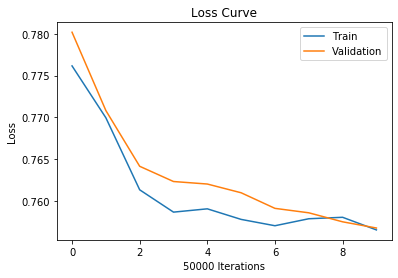

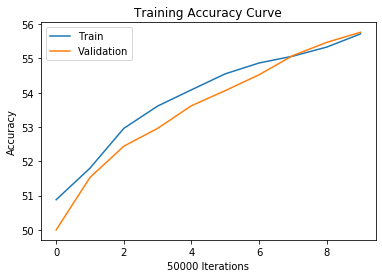

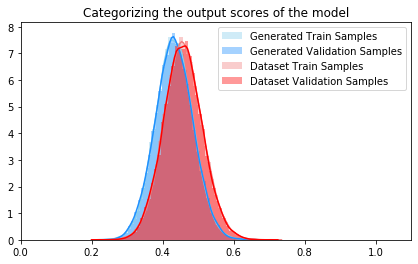

 10%|█         | 49990/491198 [05:10<51:43, 142.15it/s]

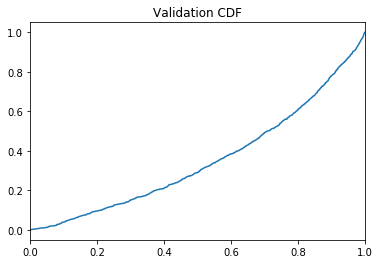

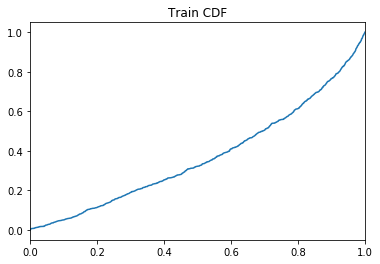

 10%|█         | 50023/491198 [05:57<150:10:39,  1.23s/it]

Training AUC at epoch 0: 0.37011081818181824
Validation AUC epoch 0: 0.3520766363636364
Training Accuracy at epoch 0: 55.714
Validation Accuracy epoch 0: 55.762


 20%|██        | 99989/491198 [11:02<44:02, 148.07it/s]   

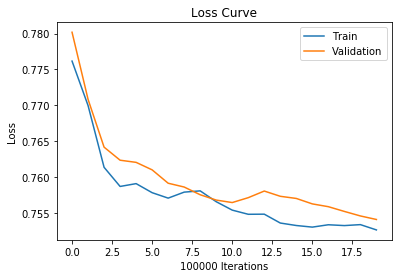

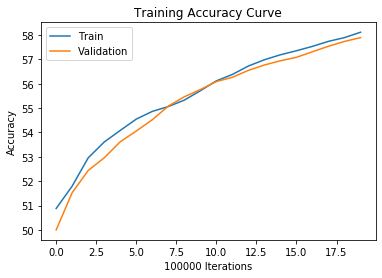

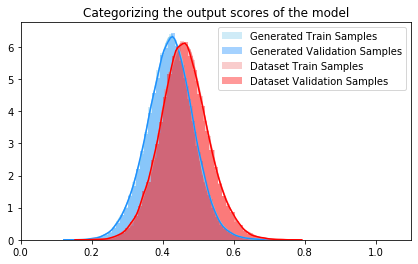

 20%|██        | 99989/491198 [11:20<44:02, 148.07it/s]

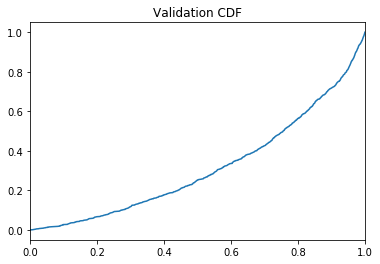

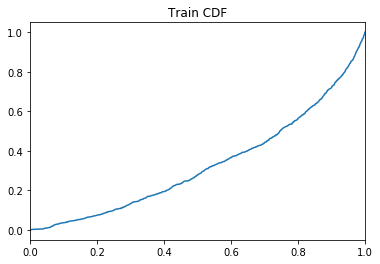

 20%|██        | 100024/491198 [11:59<118:17:07,  1.09s/it]

Training AUC at epoch 0: 0.3275580909090909
Validation AUC epoch 0: 0.31440263636363636
Training Accuracy at epoch 0: 58.116
Validation Accuracy epoch 0: 57.895


 31%|███       | 149976/491198 [16:59<35:56, 158.23it/s]   

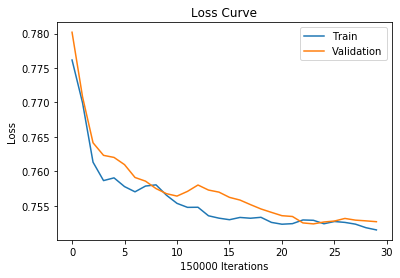

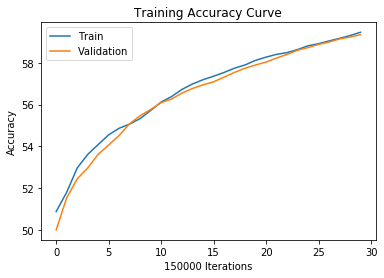

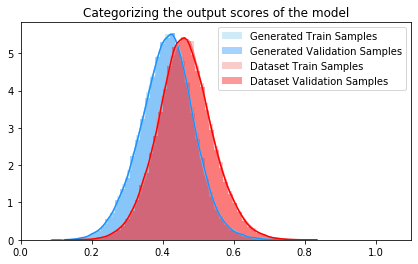

 31%|███       | 149976/491198 [17:10<35:56, 158.23it/s]

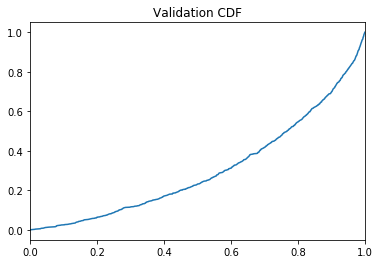

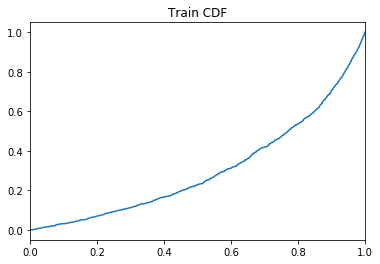

 31%|███       | 150000/491198 [17:55<67:33:53,  1.40it/s]

Training AUC at epoch 0: 0.3046540909090909
Validation AUC epoch 0: 0.30483709090909095
Training Accuracy at epoch 0: 59.46066666666667
Validation Accuracy epoch 0: 59.343333333333334


 41%|████      | 199990/491198 [23:04<27:23, 177.22it/s]  

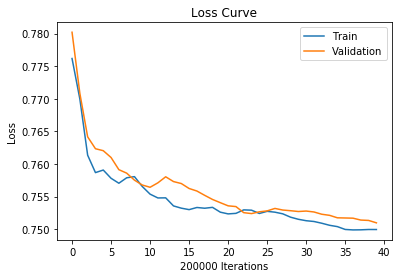

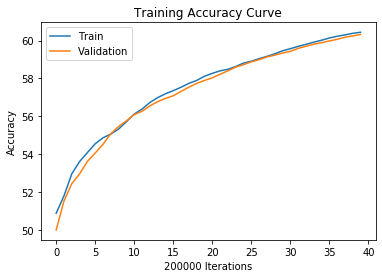

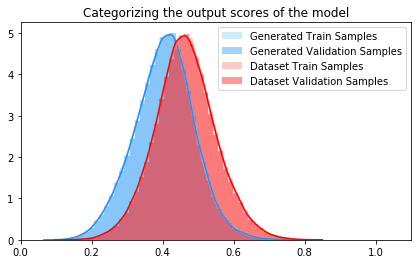

 41%|████      | 199990/491198 [23:21<27:23, 177.22it/s]

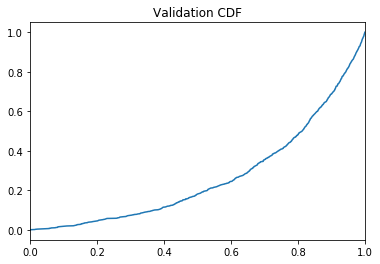

 51%|█████     | 249998/491198 [28:58<25:10, 159.70it/s]

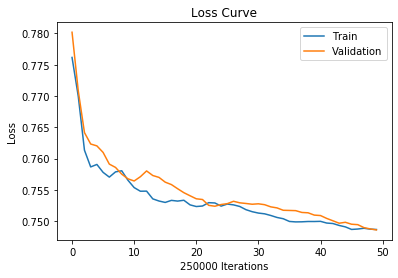

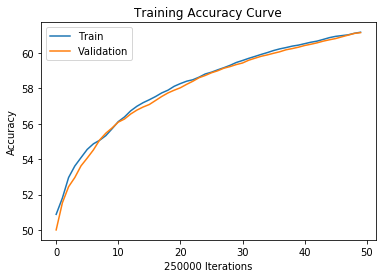

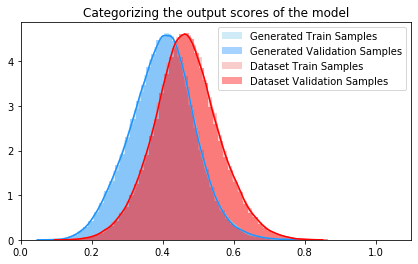

 51%|█████     | 249998/491198 [29:11<25:10, 159.70it/s]

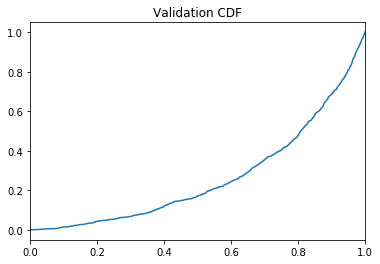

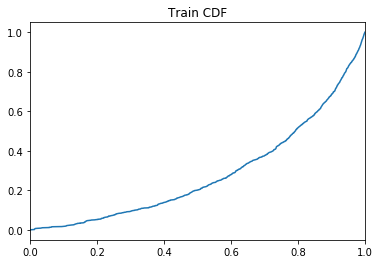

 51%|█████     | 250023/491198 [29:56<403:07:59,  6.02s/it]

Training AUC at epoch 0: 0.28339763636363635
Validation AUC epoch 0: 0.26392354545454544
Training Accuracy at epoch 0: 61.17
Validation Accuracy epoch 0: 61.148


 61%|██████    | 299982/491198 [34:43<20:11, 157.88it/s]   

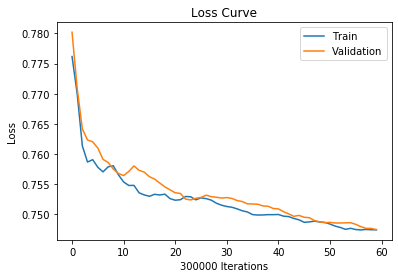

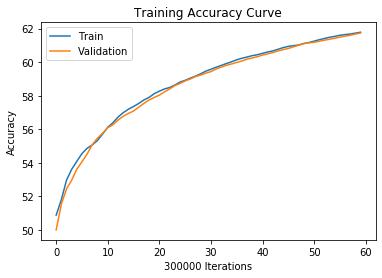

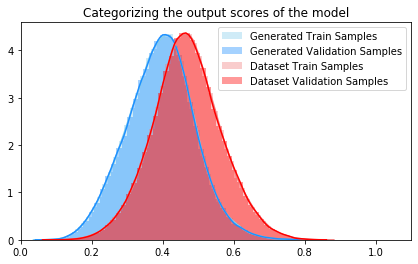

 61%|██████    | 299982/491198 [35:02<20:11, 157.88it/s]

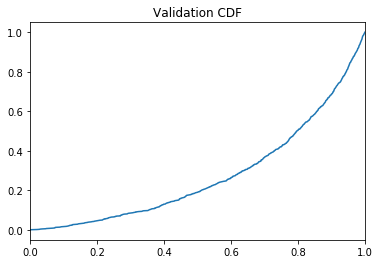

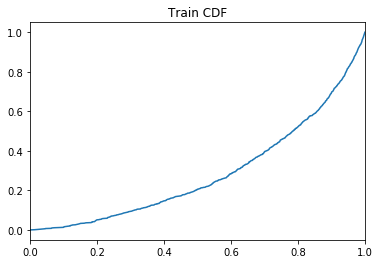

 61%|██████    | 300028/491198 [35:41<35:49:30,  1.48it/s]

Training AUC at epoch 0: 0.28586900000000004
Validation AUC epoch 0: 0.27549599999999996
Training Accuracy at epoch 0: 61.781
Validation Accuracy epoch 0: 61.73466666666667


 71%|███████▏  | 349994/491198 [40:19<12:55, 182.02it/s]  

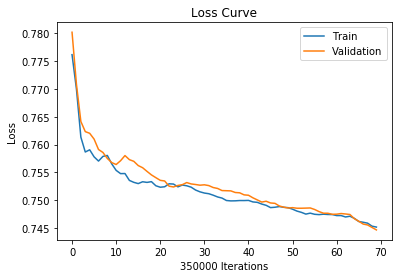

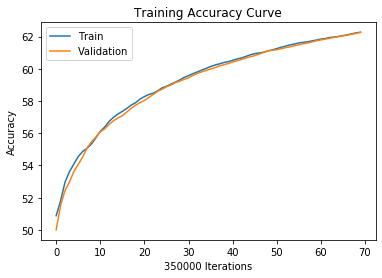

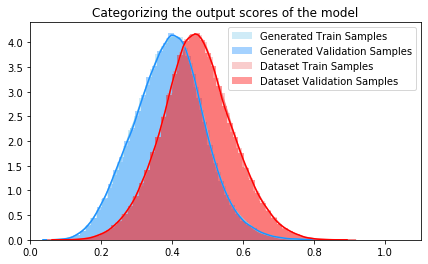

 71%|███████▏  | 349994/491198 [40:32<12:55, 182.02it/s]

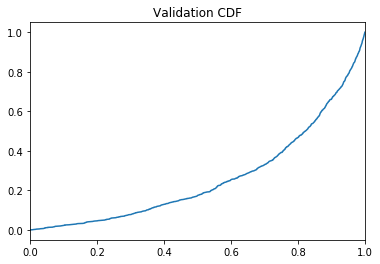

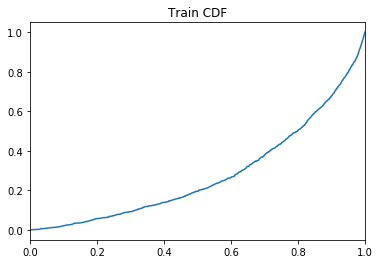

 71%|███████▏  | 350016/491198 [41:16<78:41:39,  2.01s/it] 

Training AUC at epoch 0: 0.2793026363636364
Validation AUC epoch 0: 0.2611880909090909
Training Accuracy at epoch 0: 62.26571428571429
Validation Accuracy epoch 0: 62.25514285714286


 81%|████████▏ | 399998/491198 [45:57<07:46, 195.55it/s]  

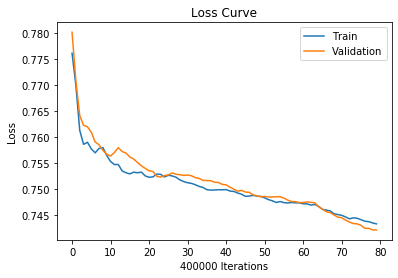

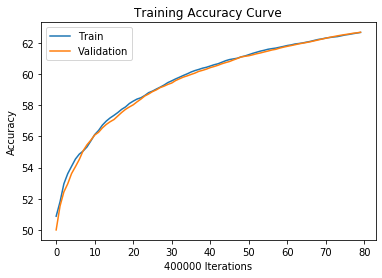

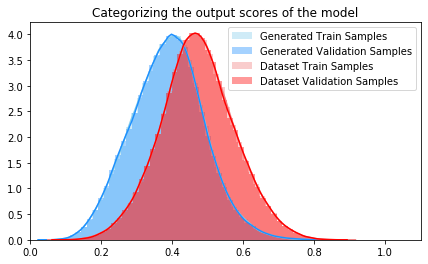

 81%|████████▏ | 399998/491198 [46:12<07:46, 195.55it/s]

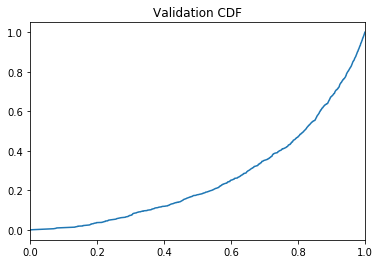

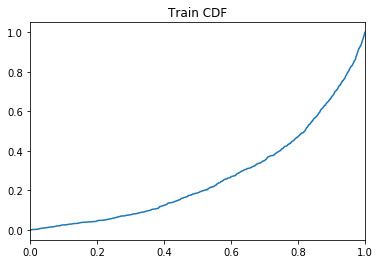

 81%|████████▏ | 400025/491198 [46:55<153:52:34,  6.08s/it]

Training AUC at epoch 0: 0.2683846363636364
Validation AUC epoch 0: 0.26202945454545457
Training Accuracy at epoch 0: 62.68
Validation Accuracy epoch 0: 62.69225


 92%|█████████▏| 449983/491198 [51:36<03:29, 196.88it/s]   

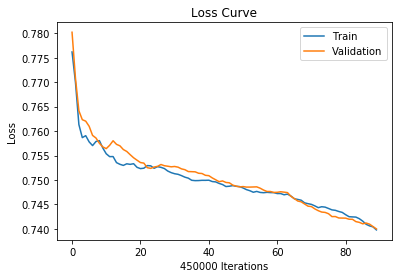

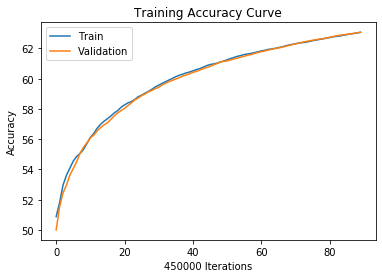

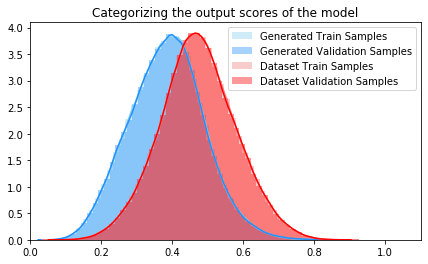

 92%|█████████▏| 449983/491198 [51:53<03:29, 196.88it/s]

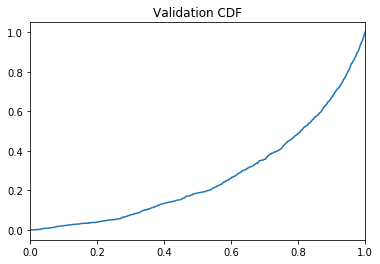

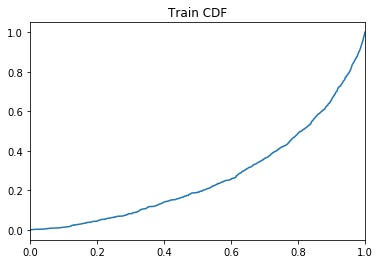

 92%|█████████▏| 450047/491198 [52:35<5:47:08,  1.98it/s] 

Training AUC at epoch 0: 0.269656
Validation AUC epoch 0: 0.268902
Training Accuracy at epoch 0: 63.074666666666666
Validation Accuracy epoch 0: 63.06933333333333


  0%|          | 23/491198 [00:00<36:39, 223.30it/s]

Saving to:  model_checkpoints/binary/BlosumNet/07292020.pth
Starting epoch: 1  with learning rate:  [0.01]


  2%|▏         | 8801/491198 [00:50<46:19, 173.58it/s]

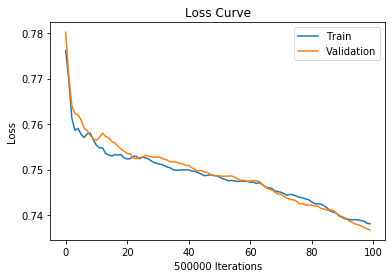

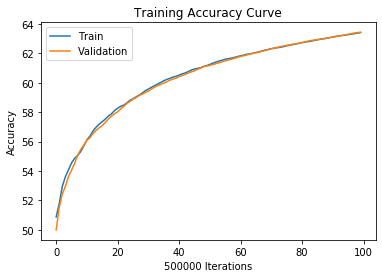

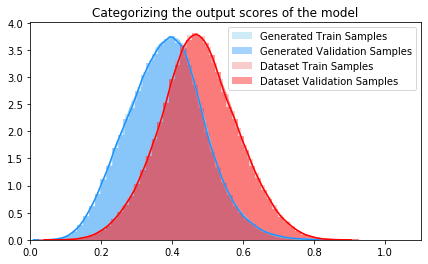

  2%|▏         | 8801/491198 [01:10<46:19, 173.58it/s]

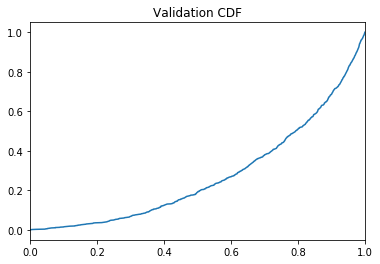

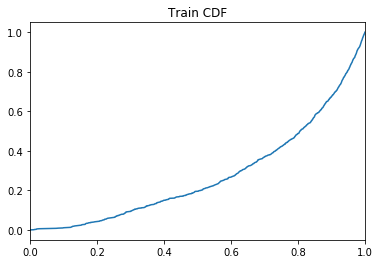

  2%|▏         | 8829/491198 [01:48<1635:05:51, 12.20s/it]

Training AUC at epoch 1: 0.2757327272727273
Validation AUC epoch 1: 0.27390736363636364
Training Accuracy at epoch 1: 63.412
Validation Accuracy epoch 1: 63.4354


 12%|█▏        | 58784/491198 [06:37<41:49, 172.31it/s]   

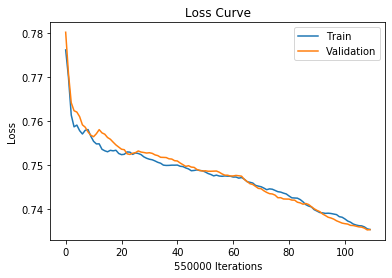

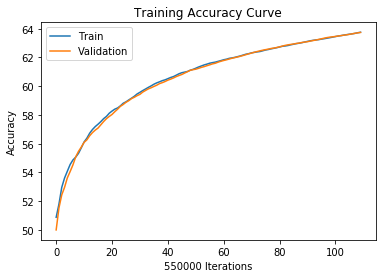

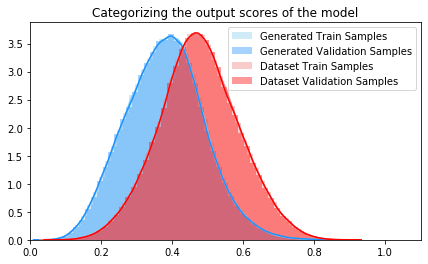

 12%|█▏        | 58784/491198 [06:50<41:49, 172.31it/s]

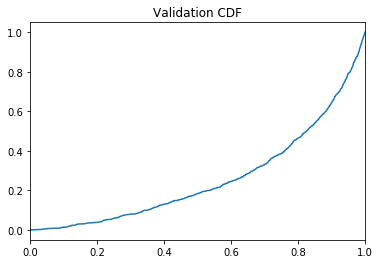

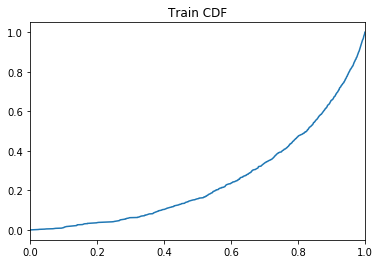

 12%|█▏        | 58818/491198 [07:36<82:55:04,  1.45it/s] 

Training AUC at epoch 1: 0.25158463636363637
Validation AUC epoch 1: 0.258102
Training Accuracy at epoch 1: 63.75381818181818
Validation Accuracy epoch 1: 63.74036363636364


 22%|██▏       | 108783/491198 [12:24<34:39, 183.86it/s] 

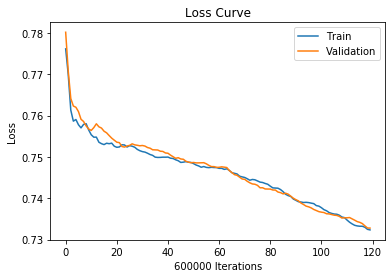

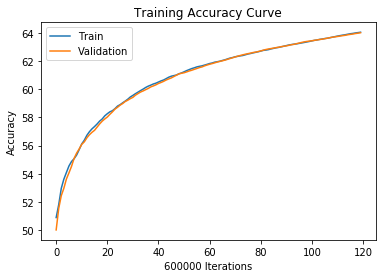

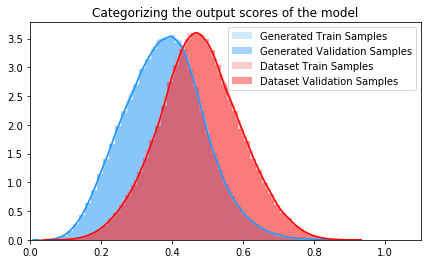

 22%|██▏       | 108783/491198 [12:41<34:39, 183.86it/s]

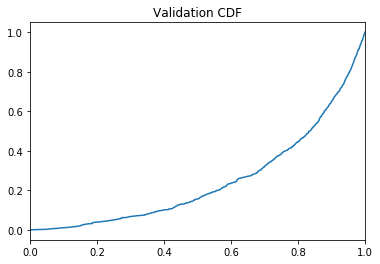

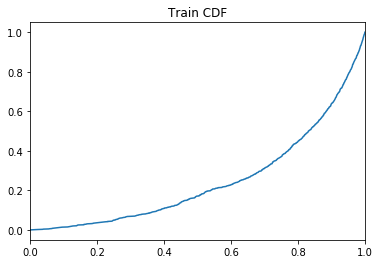

 22%|██▏       | 108825/491198 [13:24<70:19:25,  1.51it/s] 

Training AUC at epoch 1: 0.24797836363636364
Validation AUC epoch 1: 0.24784090909090906
Training Accuracy at epoch 1: 64.06666666666666
Validation Accuracy epoch 1: 64.03266666666667


 32%|███▏      | 158792/491198 [18:11<35:55, 154.23it/s]  

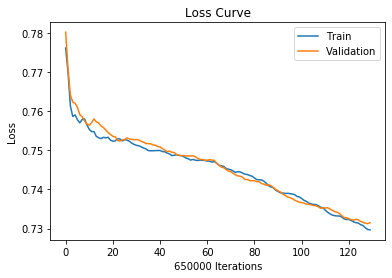

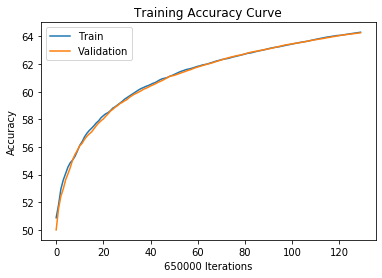

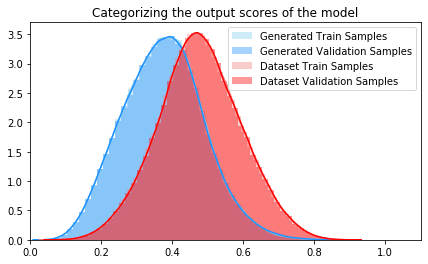

 32%|███▏      | 158792/491198 [18:21<35:55, 154.23it/s]

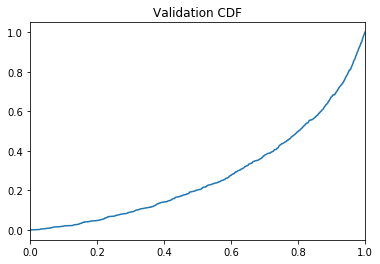

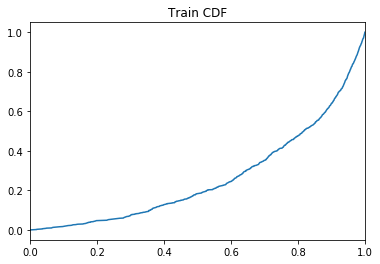

 32%|███▏      | 158825/491198 [19:11<116:58:28,  1.27s/it]

Training AUC at epoch 1: 0.26176172727272723
Validation AUC epoch 1: 0.27754636363636365
Training Accuracy at epoch 1: 64.30569230769231
Validation Accuracy epoch 1: 64.26476923076923


 43%|████▎     | 208801/491198 [23:50<27:00, 174.26it/s]   

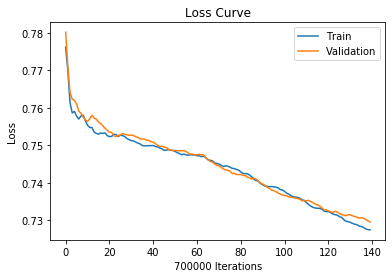

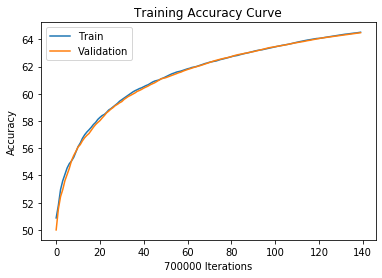

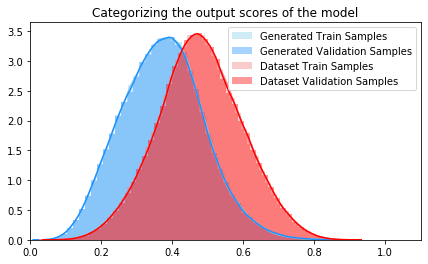

 43%|████▎     | 208801/491198 [24:02<27:00, 174.26it/s]

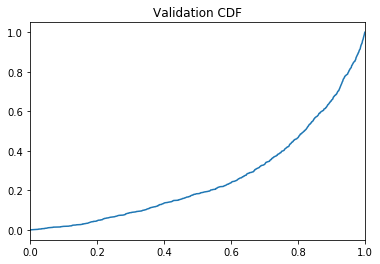

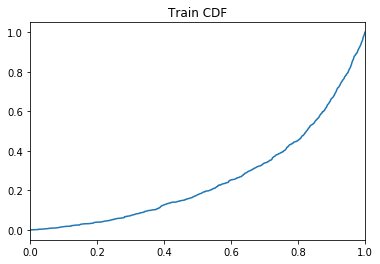

 43%|████▎     | 208826/491198 [24:49<977:20:14, 12.46s/it] 

Training AUC at epoch 1: 0.2596820909090909
Validation AUC epoch 1: 0.262305
Training Accuracy at epoch 1: 64.52628571428572
Validation Accuracy epoch 1: 64.49242857142858


 53%|█████▎    | 258793/491198 [29:36<21:36, 179.22it/s]   

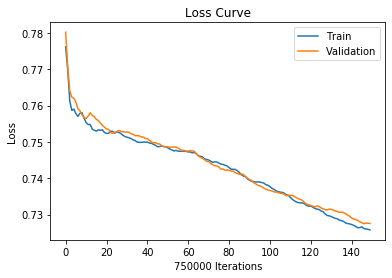

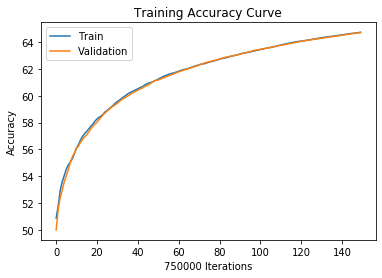

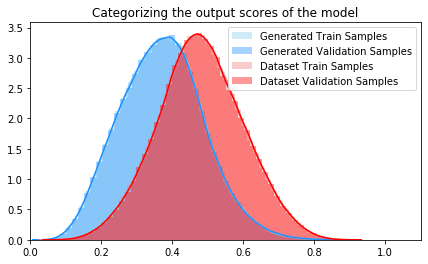

 53%|█████▎    | 258793/491198 [29:52<21:36, 179.22it/s]

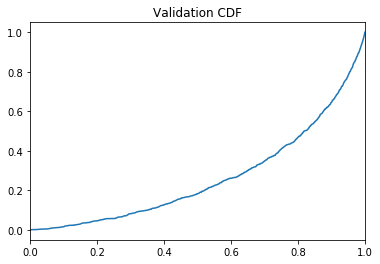

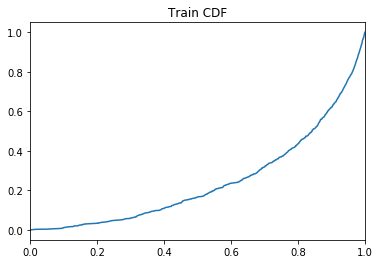

 53%|█████▎    | 258818/491198 [30:36<90:08:29,  1.40s/it] 

Training AUC at epoch 1: 0.244036
Validation AUC epoch 1: 0.2634182727272727
Training Accuracy at epoch 1: 64.7404
Validation Accuracy epoch 1: 64.70973333333333


 63%|██████▎   | 308781/491198 [35:22<17:38, 172.35it/s]  

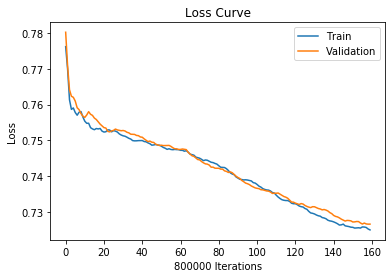

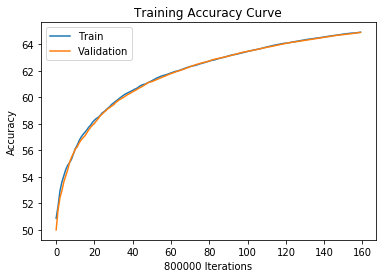

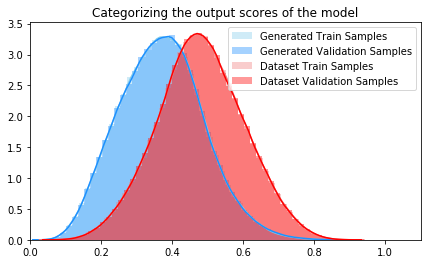

 63%|██████▎   | 308781/491198 [35:33<17:38, 172.35it/s]

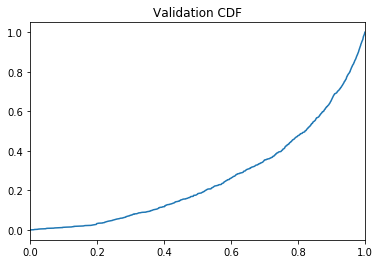

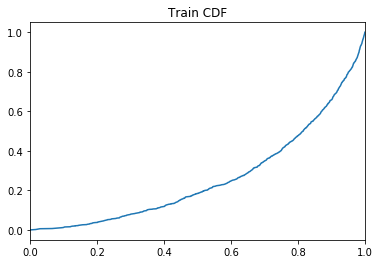

 63%|██████▎   | 308827/491198 [36:23<31:12:04,  1.62it/s]

Training AUC at epoch 1: 0.26226863636363634
Validation AUC epoch 1: 0.261003
Training Accuracy at epoch 1: 64.903125
Validation Accuracy epoch 1: 64.8925


 73%|███████▎  | 358782/491198 [41:09<11:17, 195.32it/s]  

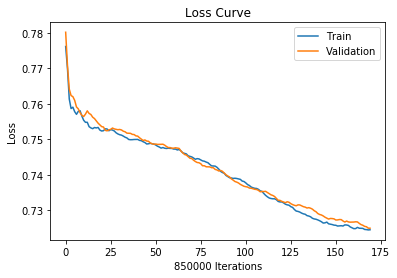

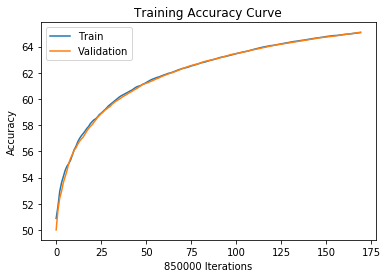

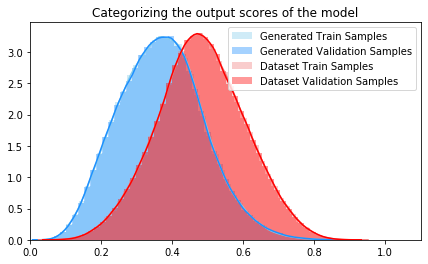

 73%|███████▎  | 358782/491198 [41:23<11:17, 195.32it/s]

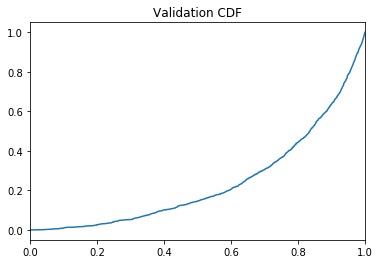

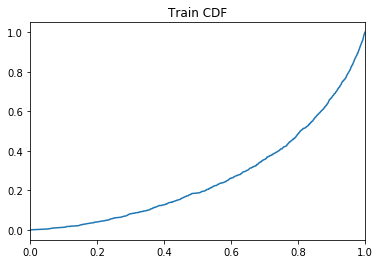

 73%|███████▎  | 358827/491198 [42:10<23:34:05,  1.56it/s]

Training AUC at epoch 1: 0.2667351818181818
Validation AUC epoch 1: 0.238385
Training Accuracy at epoch 1: 65.0644705882353
Validation Accuracy epoch 1: 65.08917647058824


 83%|████████▎ | 408789/491198 [46:44<08:24, 163.40it/s]  

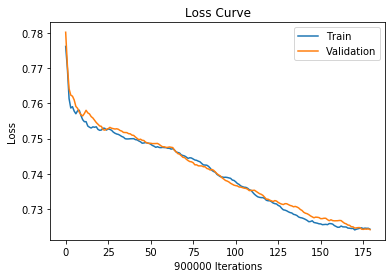

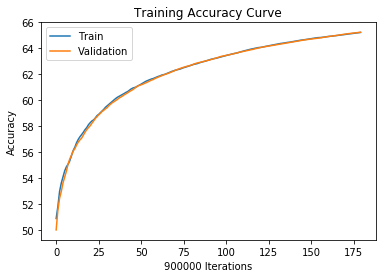

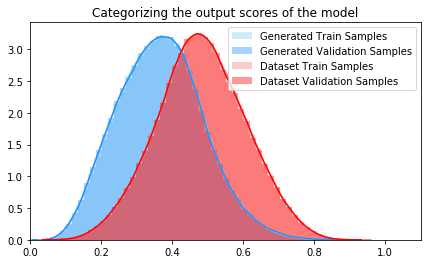

 83%|████████▎ | 408789/491198 [47:03<08:24, 163.40it/s]

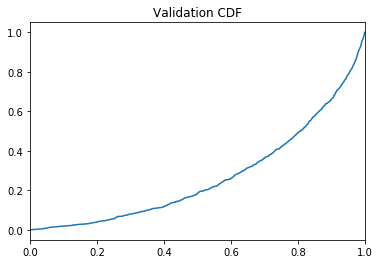

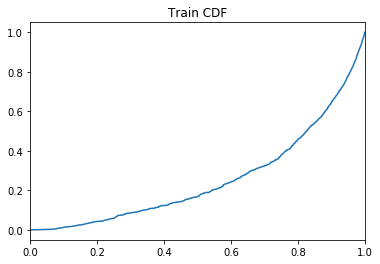

 83%|████████▎ | 408825/491198 [47:45<22:34:55,  1.01it/s]

Training AUC at epoch 1: 0.25528154545454546
Validation AUC epoch 1: 0.268273
Training Accuracy at epoch 1: 65.23177777777778
Validation Accuracy epoch 1: 65.24811111111111


 93%|█████████▎| 458792/491198 [52:31<03:04, 175.38it/s]  

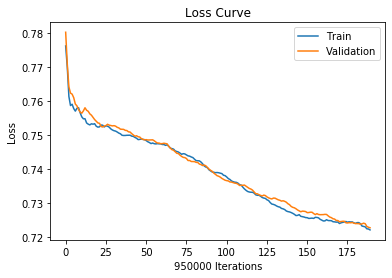

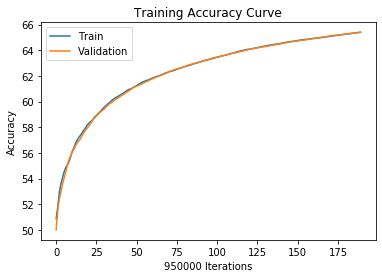

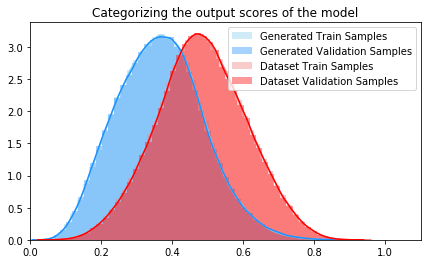

 93%|█████████▎| 458792/491198 [52:43<03:04, 175.38it/s]

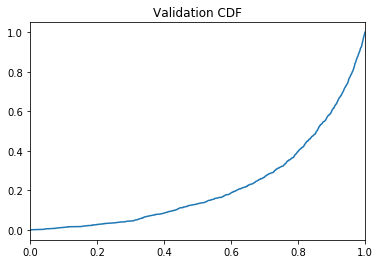

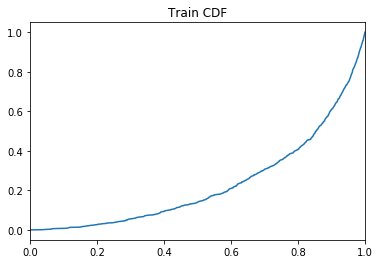

 93%|█████████▎| 458818/491198 [53:34<11:47:55,  1.31s/it]

Training AUC at epoch 1: 0.229963
Validation AUC epoch 1: 0.22038254545454544
Training Accuracy at epoch 1: 65.3982105263158
Validation Accuracy epoch 1: 65.39473684210526


  0%|          | 18/491198 [00:00<47:11, 173.49it/s]

Saving to:  model_checkpoints/binary/BlosumNet/07292020.pth
Starting epoch: 2  with learning rate:  [0.01]


  4%|▎         | 17597/491198 [01:41<41:27, 190.39it/s]

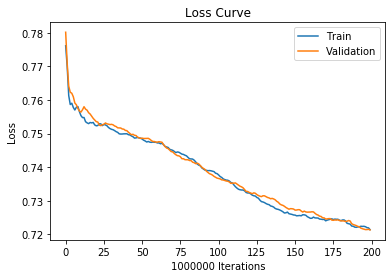

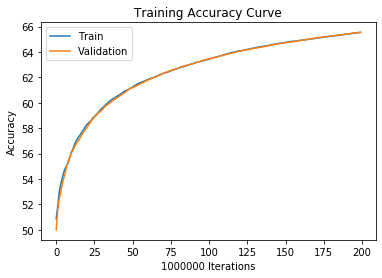

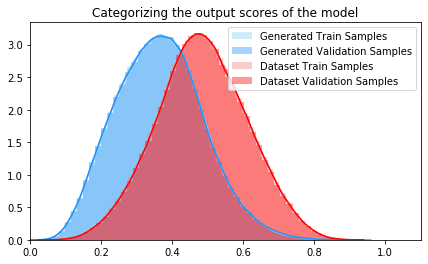

  4%|▎         | 17597/491198 [02:00<41:27, 190.39it/s]

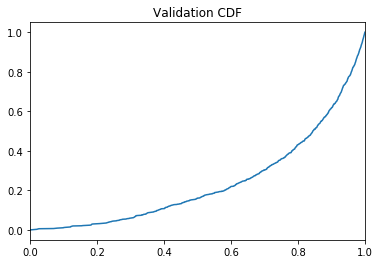

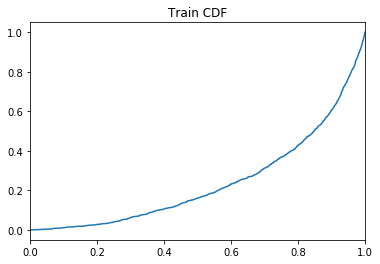

  4%|▎         | 17628/491198 [02:43<245:29:47,  1.87s/it]

Training AUC at epoch 2: 0.23881690909090908
Validation AUC epoch 2: 0.23901209090909092
Training Accuracy at epoch 2: 65.5412
Validation Accuracy epoch 2: 65.5525


 14%|█▍        | 67591/491198 [07:31<46:55, 150.45it/s]   

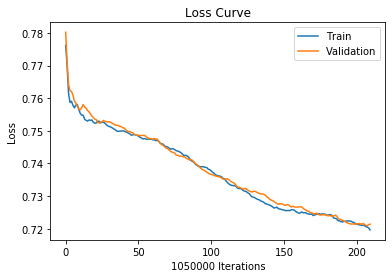

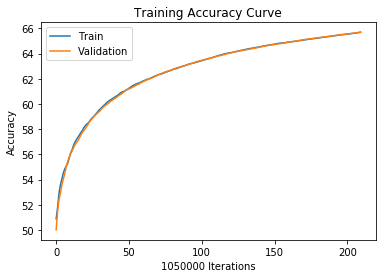

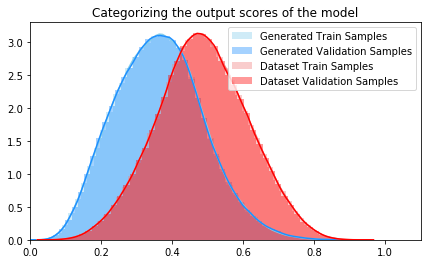

 14%|█▍        | 67591/491198 [07:50<46:55, 150.45it/s]

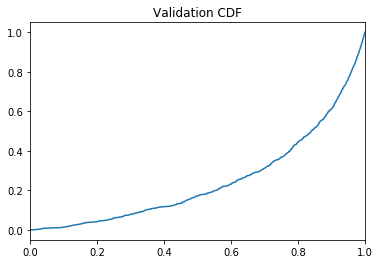

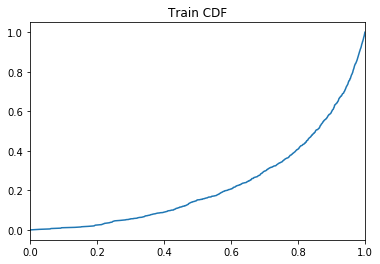

 14%|█▍        | 67627/491198 [08:39<128:56:22,  1.10s/it]

Training AUC at epoch 2: 0.22840863636363637
Validation AUC epoch 2: 0.24791027272727273
Training Accuracy at epoch 2: 65.69609523809524
Validation Accuracy epoch 2: 65.6947619047619


 24%|██▍       | 117598/491198 [13:12<36:36, 170.07it/s]  

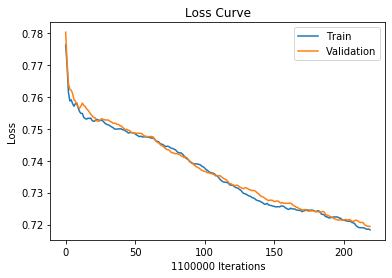

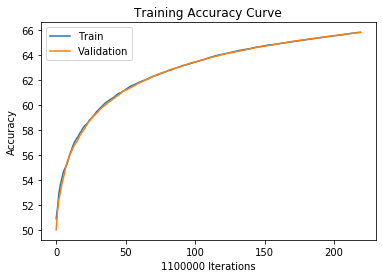

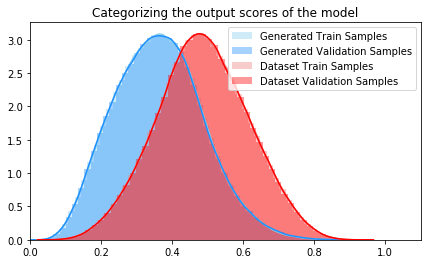

 24%|██▍       | 117598/491198 [13:30<36:36, 170.07it/s]

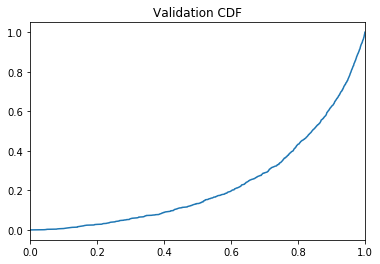

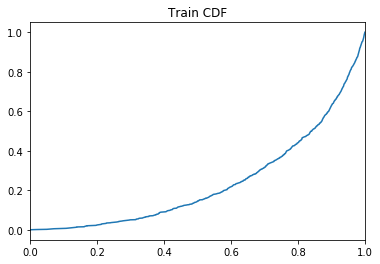

 24%|██▍       | 117627/491198 [14:15<226:42:10,  2.18s/it]

Training AUC at epoch 2: 0.23724054545454545
Validation AUC epoch 2: 0.23025172727272727
Training Accuracy at epoch 2: 65.82618181818182
Validation Accuracy epoch 2: 65.83718181818182


 34%|███▍      | 167586/491198 [18:58<30:20, 177.77it/s]   

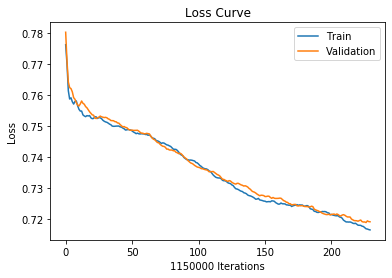

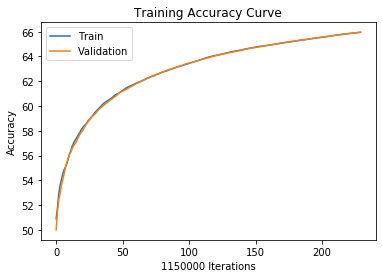

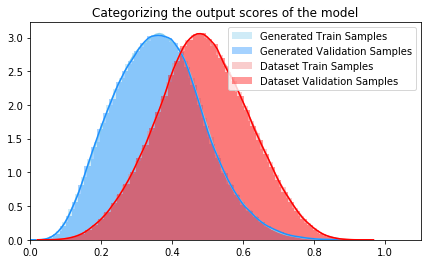

 34%|███▍      | 167586/491198 [19:11<30:20, 177.77it/s]

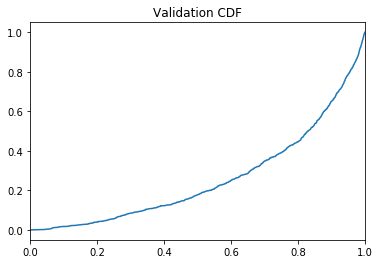

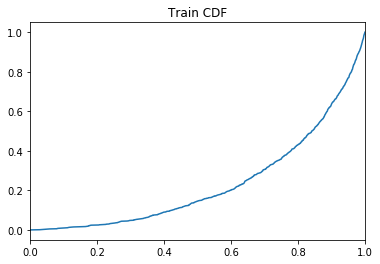

 34%|███▍      | 167620/491198 [20:00<65:40:22,  1.37it/s]

Training AUC at epoch 2: 0.23329672727272727
Validation AUC epoch 2: 0.2577542727272727
Training Accuracy at epoch 2: 65.95539130434783
Validation Accuracy epoch 2: 65.95


 44%|████▍     | 217596/491198 [24:48<24:23, 186.97it/s]  

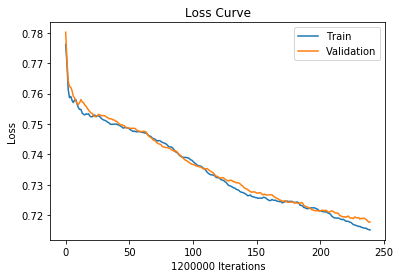

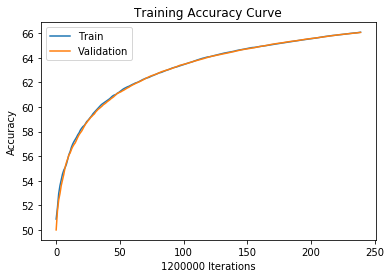

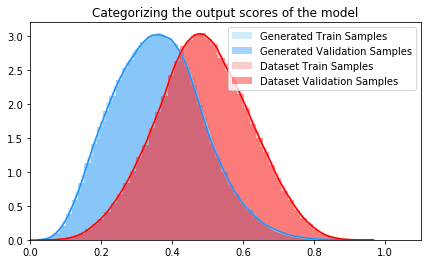

 44%|████▍     | 217596/491198 [25:01<24:23, 186.97it/s]

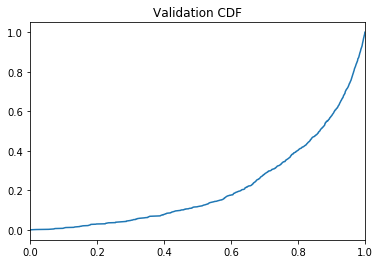

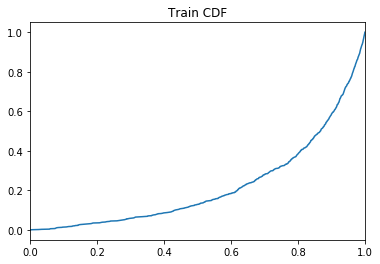

 44%|████▍     | 217627/491198 [25:51<125:39:35,  1.65s/it]

Training AUC at epoch 2: 0.21994863636363637
Validation AUC epoch 2: 0.21548045454545456
Training Accuracy at epoch 2: 66.07716666666667
Validation Accuracy epoch 2: 66.063


 54%|█████▍    | 267586/491198 [30:37<15:40, 237.79it/s]   

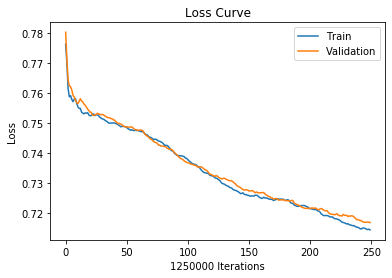

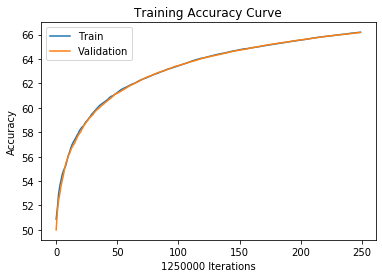

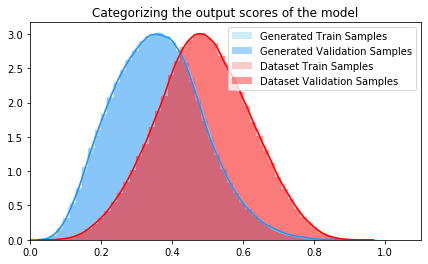

 54%|█████▍    | 267586/491198 [30:52<15:40, 237.79it/s]

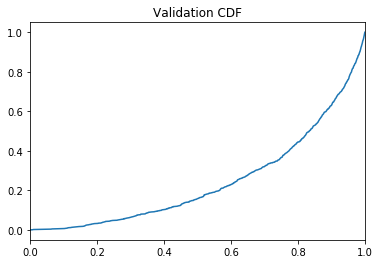

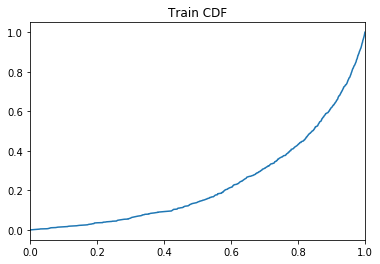

 54%|█████▍    | 267628/491198 [31:39<45:35:24,  1.36it/s]

Training AUC at epoch 2: 0.23693118181818182
Validation AUC epoch 2: 0.24433327272727273
Training Accuracy at epoch 2: 66.19168
Validation Accuracy epoch 2: 66.17576


 65%|██████▍   | 317583/491198 [36:30<19:00, 152.28it/s]  

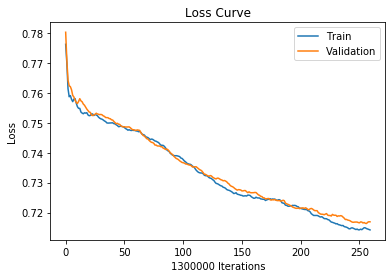

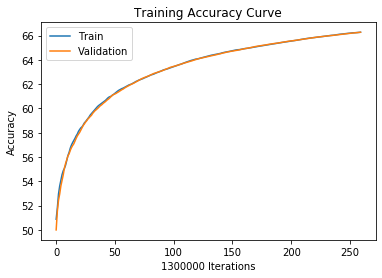

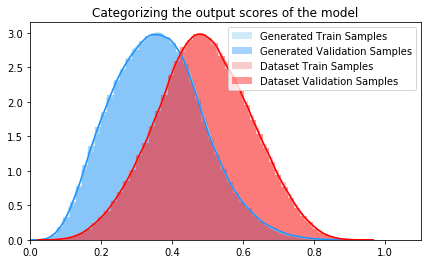

 65%|██████▍   | 317583/491198 [36:42<19:00, 152.28it/s]

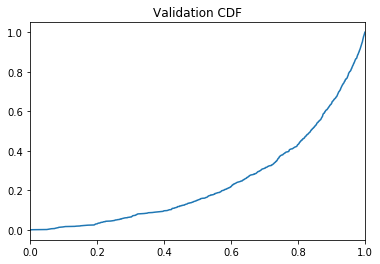

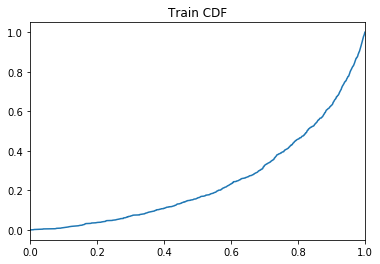

 65%|██████▍   | 317627/491198 [37:33<30:28:14,  1.58it/s]

Training AUC at epoch 2: 0.248593
Validation AUC epoch 2: 0.2423767272727273
Training Accuracy at epoch 2: 66.27584615384616
Validation Accuracy epoch 2: 66.27638461538461


 75%|███████▍  | 367589/491198 [42:23<11:47, 174.80it/s]  

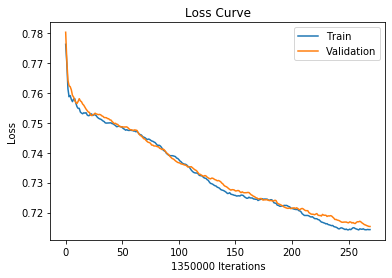

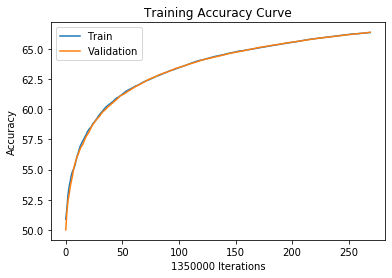

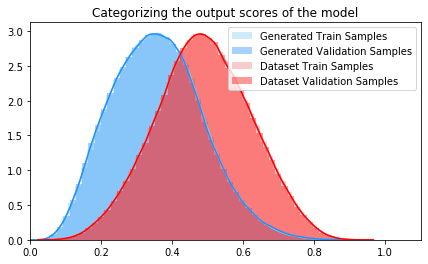

 75%|███████▍  | 367589/491198 [42:42<11:47, 174.80it/s]

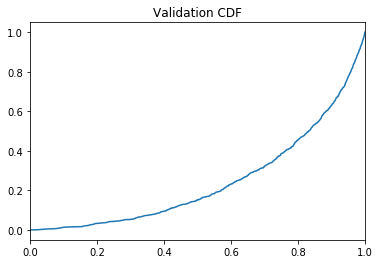

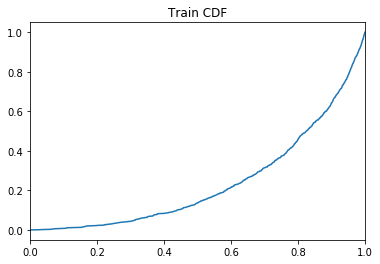

 75%|███████▍  | 367620/491198 [43:26<30:45:59,  1.12it/s]

Training AUC at epoch 2: 0.2375248181818182
Validation AUC epoch 2: 0.24330445454545457
Training Accuracy at epoch 2: 66.3597037037037
Validation Accuracy epoch 2: 66.38466666666666


 85%|████████▌ | 417602/491198 [48:16<06:36, 185.41it/s]  

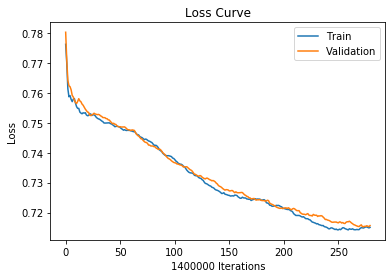

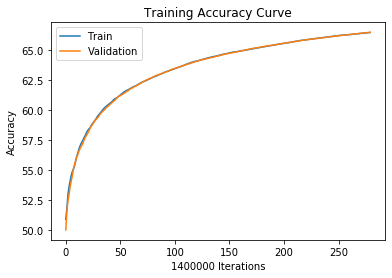

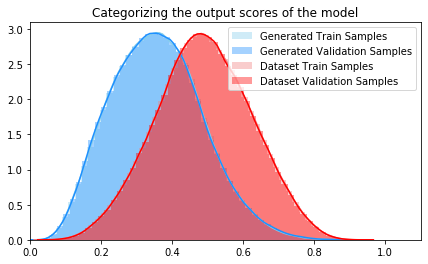

 85%|████████▌ | 417602/491198 [48:33<06:36, 185.41it/s]

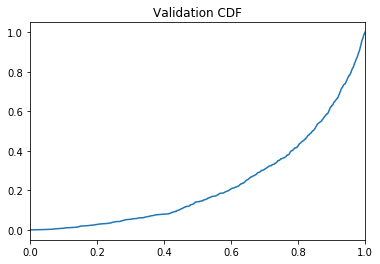

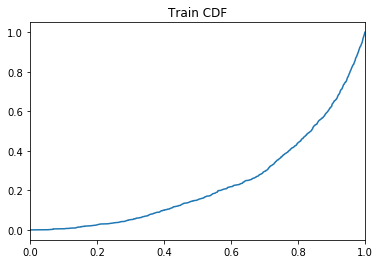

 85%|████████▌ | 417652/491198 [49:20<95:51:18,  4.69s/it] 

Training AUC at epoch 2: 0.23757445454545456
Validation AUC epoch 2: 0.23237063636363636
Training Accuracy at epoch 2: 66.45664285714285
Validation Accuracy epoch 2: 66.47964285714286


 95%|█████████▌| 467588/491198 [54:01<02:24, 163.44it/s]  

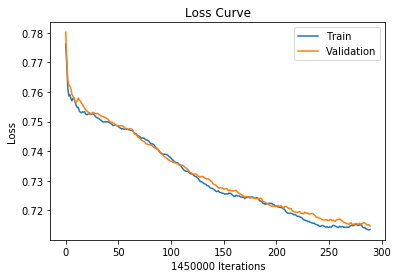

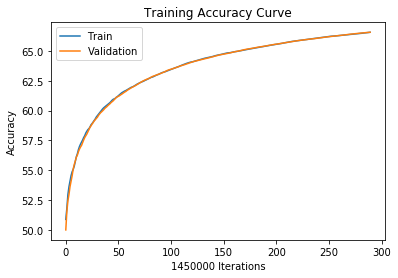

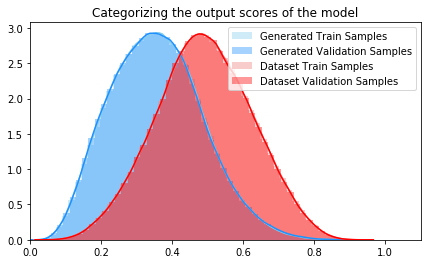

 95%|█████████▌| 467588/491198 [54:13<02:24, 163.44it/s]

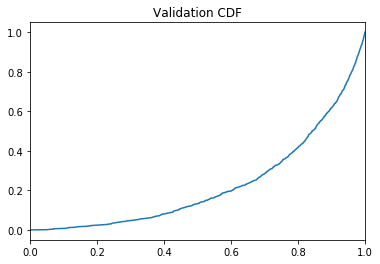

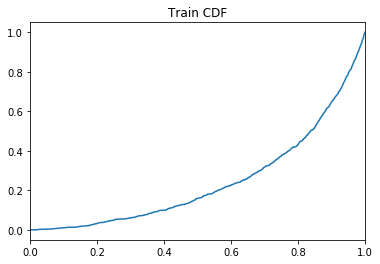

 95%|█████████▌| 467633/491198 [55:05<5:33:28,  1.18it/s]

Training AUC at epoch 2: 0.24385545454545454
Validation AUC epoch 2: 0.22615890909090908
Training Accuracy at epoch 2: 66.554
Validation Accuracy epoch 2: 66.55806896551724


  0%|          | 21/491198 [00:00<39:51, 205.43it/s]

Saving to:  model_checkpoints/binary/BlosumNet/07292020.pth
Starting epoch: 3  with learning rate:  [0.01]


  5%|▌         | 26396/491198 [02:31<47:13, 164.04it/s]

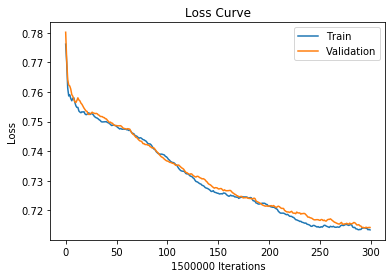

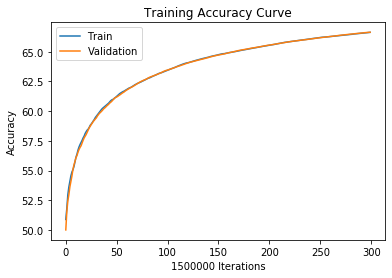

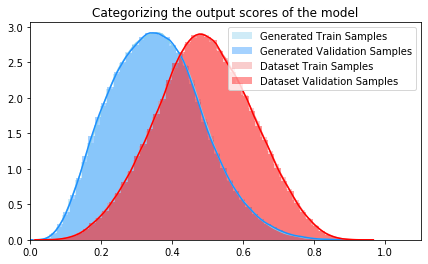

  5%|▌         | 26396/491198 [02:50<47:13, 164.04it/s]

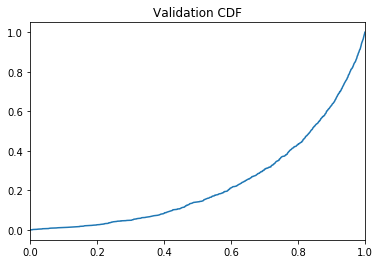

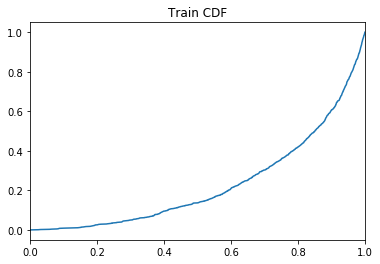

  5%|▌         | 26430/491198 [03:35<175:22:25,  1.36s/it]

Training AUC at epoch 3: 0.2293999090909091
Validation AUC epoch 3: 0.23501127272727274
Training Accuracy at epoch 3: 66.63413333333334
Validation Accuracy epoch 3: 66.64446666666667


 16%|█▌        | 76402/491198 [08:20<39:01, 177.19it/s]   

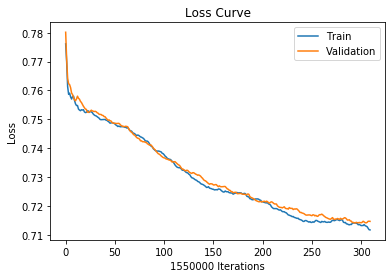

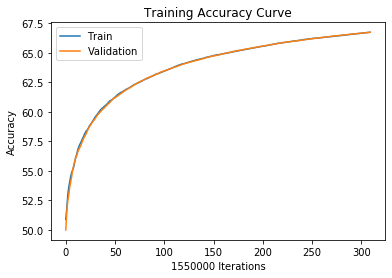

 16%|█▌        | 76402/491198 [08:30<39:01, 177.19it/s]

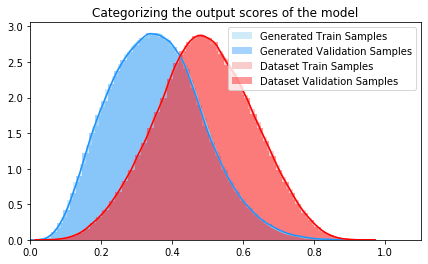

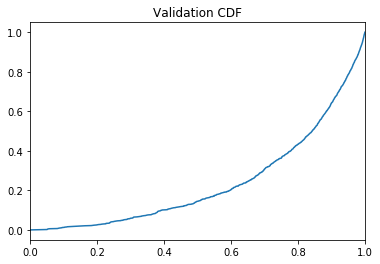

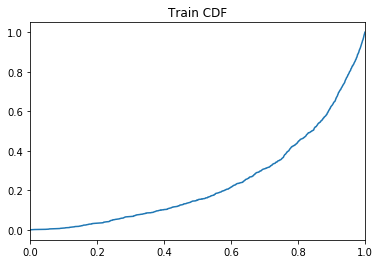

 16%|█▌        | 76422/491198 [09:24<391:10:06,  3.40s/it]

Training AUC at epoch 3: 0.24102381818181817
Validation AUC epoch 3: 0.23706945454545453
Training Accuracy at epoch 3: 66.73522580645161
Validation Accuracy epoch 3: 66.73387096774194


 26%|██▌       | 126398/491198 [14:11<31:36, 192.38it/s]  

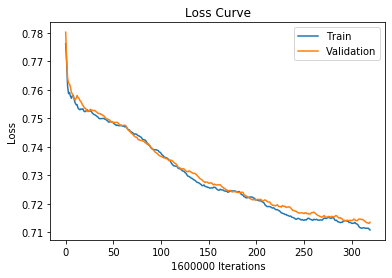

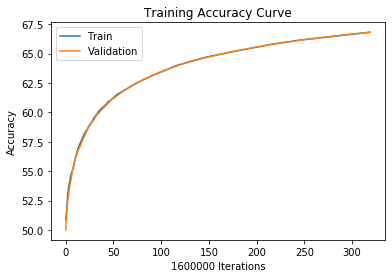

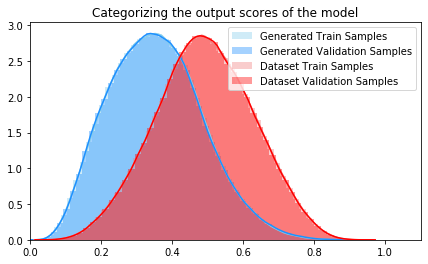

 26%|██▌       | 126398/491198 [14:30<31:36, 192.38it/s]

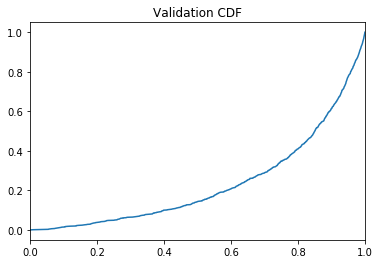

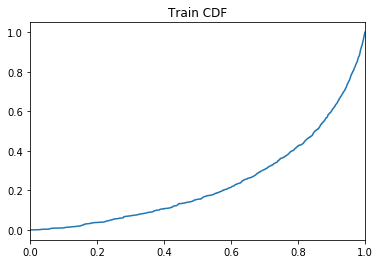

 26%|██▌       | 126430/491198 [15:16<173:38:41,  1.71s/it]

Training AUC at epoch 3: 0.2367819090909091
Validation AUC epoch 3: 0.23278072727272725
Training Accuracy at epoch 3: 66.8168125
Validation Accuracy epoch 3: 66.8225625


 36%|███▌      | 176403/491198 [20:03<33:12, 158.00it/s]   

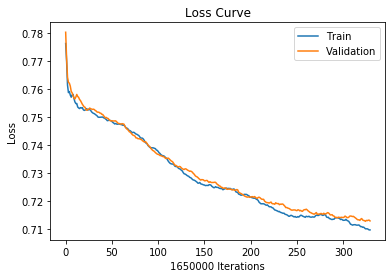

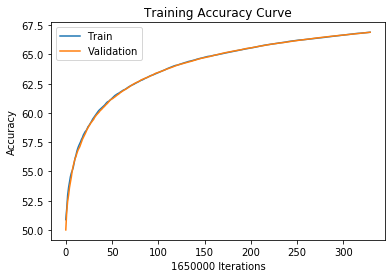

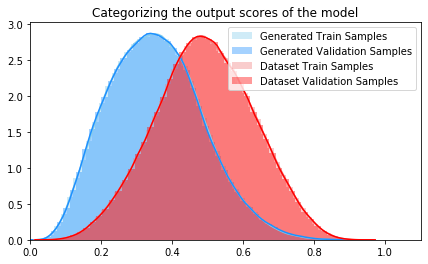

 36%|███▌      | 176403/491198 [20:20<33:12, 158.00it/s]

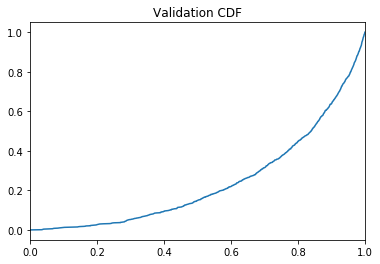

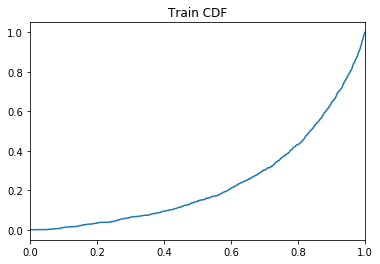

 36%|███▌      | 176431/491198 [21:09<399:52:31,  4.57s/it]

Training AUC at epoch 3: 0.23828327272727273
Validation AUC epoch 3: 0.24016563636363636
Training Accuracy at epoch 3: 66.8949696969697
Validation Accuracy epoch 3: 66.89345454545455


 46%|████▌     | 226387/491198 [25:53<28:16, 156.11it/s]   

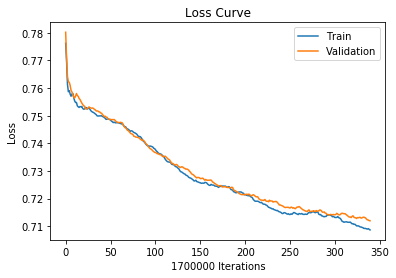

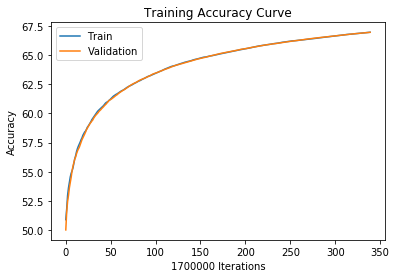

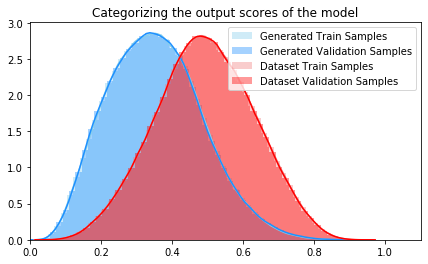

 46%|████▌     | 226387/491198 [26:11<28:16, 156.11it/s]

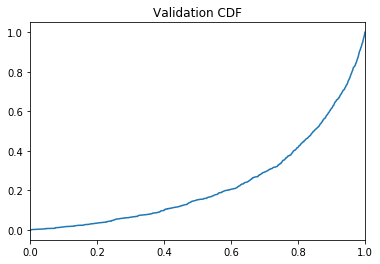

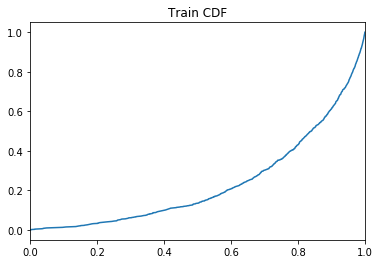

 46%|████▌     | 226431/491198 [26:59<53:56:05,  1.36it/s]

Training AUC at epoch 3: 0.23415418181818182
Validation AUC epoch 3: 0.2332488181818182
Training Accuracy at epoch 3: 66.97017647058823
Validation Accuracy epoch 3: 66.96376470588235


 56%|█████▋    | 276405/491198 [31:40<17:02, 210.10it/s]  

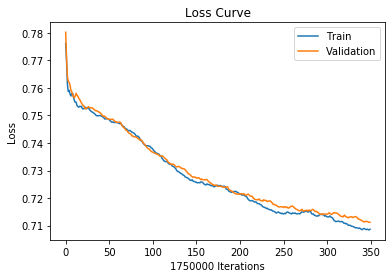

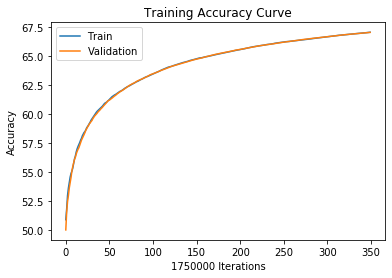

 56%|█████▋    | 276405/491198 [31:51<17:02, 210.10it/s]

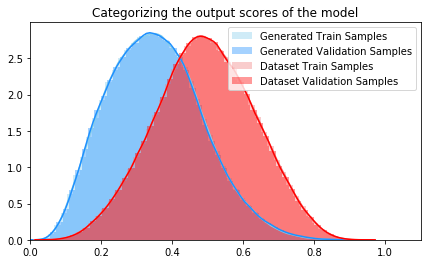

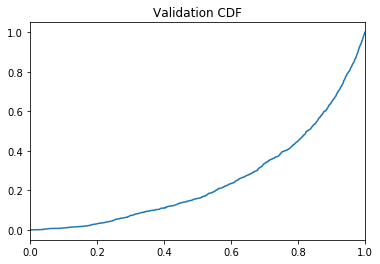

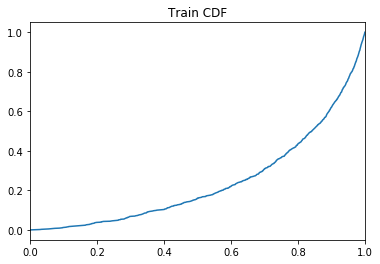

 56%|█████▋    | 276422/491198 [32:47<834:00:49, 13.98s/it] 

Training AUC at epoch 3: 0.24064554545454545
Validation AUC epoch 3: 0.2508888181818182
Training Accuracy at epoch 3: 67.0416
Validation Accuracy epoch 3: 67.02948571428571


 66%|██████▋   | 326391/491198 [37:36<14:34, 188.42it/s]   

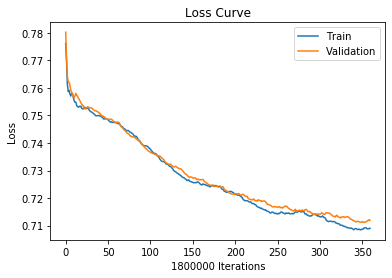

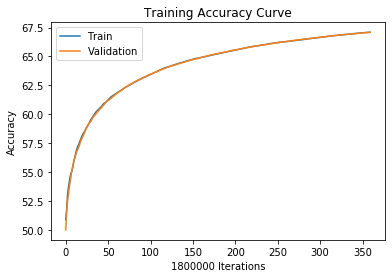

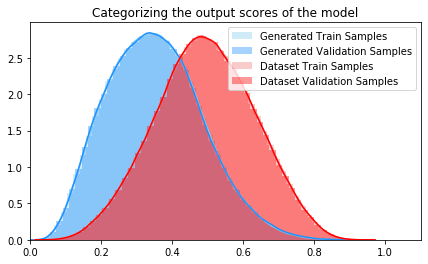

 66%|██████▋   | 326391/491198 [37:51<14:34, 188.42it/s]

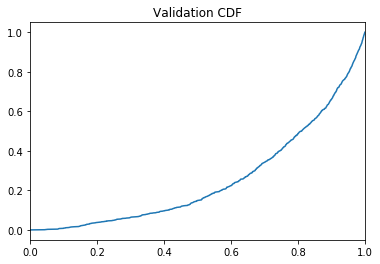

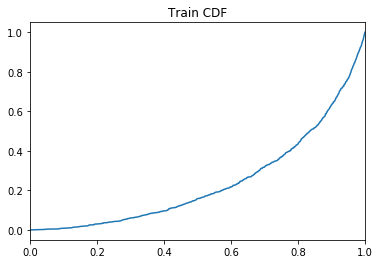

 66%|██████▋   | 326430/491198 [38:43<43:04:15,  1.06it/s]

Training AUC at epoch 3: 0.24029763636363638
Validation AUC epoch 3: 0.25205127272727273
Training Accuracy at epoch 3: 67.09261111111111
Validation Accuracy epoch 3: 67.09138888888889


 77%|███████▋  | 376395/491198 [43:26<12:40, 151.05it/s]  

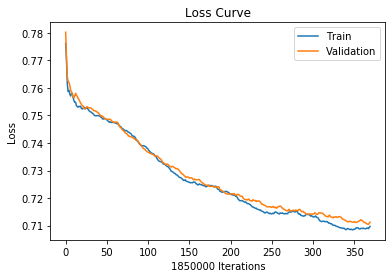

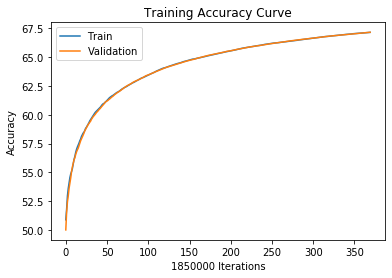

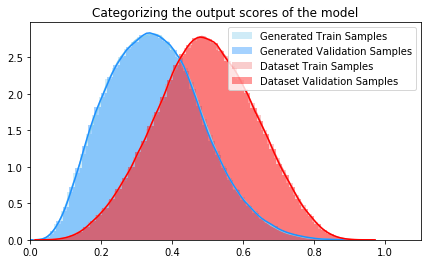

 77%|███████▋  | 376395/491198 [43:41<12:40, 151.05it/s]

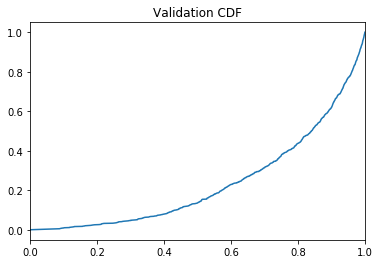

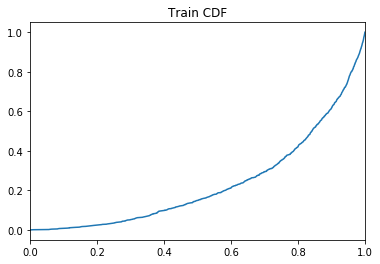

 77%|███████▋  | 376430/491198 [44:34<40:58:42,  1.29s/it]

Training AUC at epoch 3: 0.2325339090909091
Validation AUC epoch 3: 0.23613800000000001
Training Accuracy at epoch 3: 67.15254054054054
Validation Accuracy epoch 3: 67.16497297297298


 87%|████████▋ | 426383/491198 [49:17<06:58, 154.72it/s]  

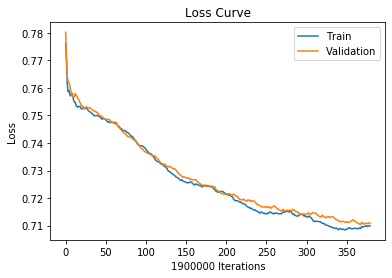

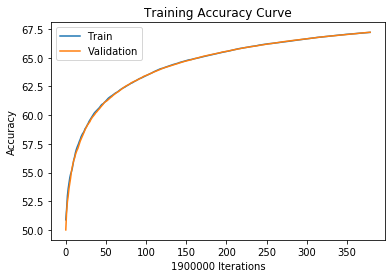

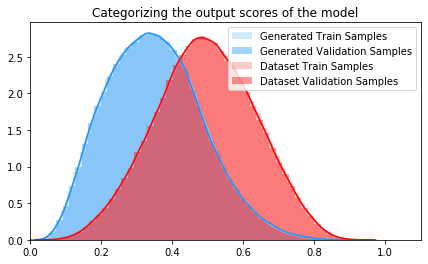

 87%|████████▋ | 426383/491198 [49:32<06:58, 154.72it/s]

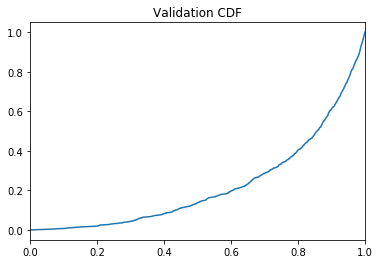

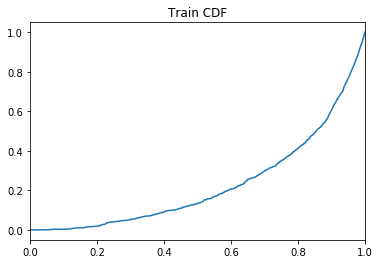

 87%|████████▋ | 426430/491198 [50:24<11:12:27,  1.61it/s]

Training AUC at epoch 3: 0.22765118181818184
Validation AUC epoch 3: 0.22320063636363635
Training Accuracy at epoch 3: 67.21542105263158
Validation Accuracy epoch 3: 67.2278947368421


 97%|█████████▋| 476401/491198 [55:07<01:24, 175.98it/s]  

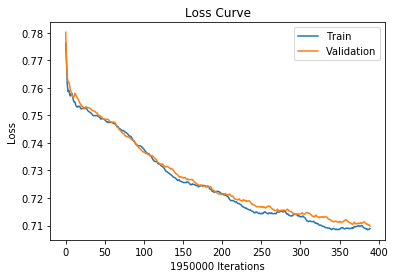

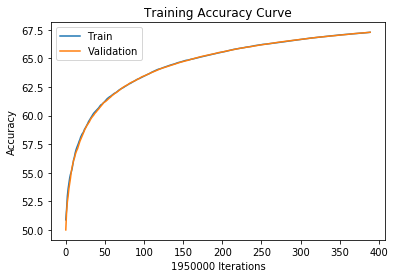

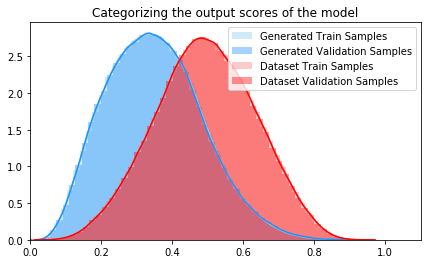

 97%|█████████▋| 476401/491198 [55:22<01:24, 175.98it/s]

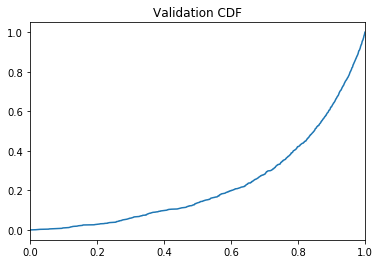

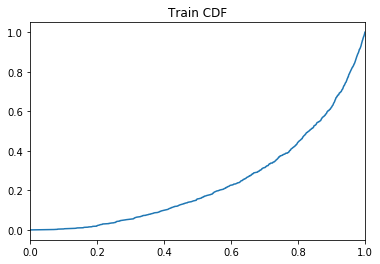

 97%|█████████▋| 476422/491198 [56:15<11:42:23,  2.85s/it]

Training AUC at epoch 3: 0.24019172727272728
Validation AUC epoch 3: 0.2303931818181818
Training Accuracy at epoch 3: 67.27928205128205
Validation Accuracy epoch 3: 67.28533333333333


  0%|          | 17/491198 [00:00<50:00, 163.70it/s]

Saving to:  model_checkpoints/binary/BlosumNet/07292020.pth
Starting epoch: 4  with learning rate:  [0.01]


  7%|▋         | 35195/491198 [03:20<38:50, 195.69it/s]

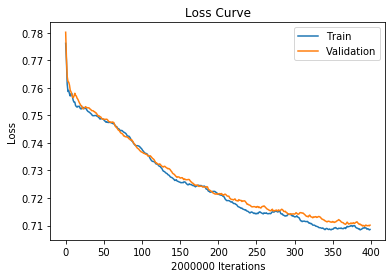

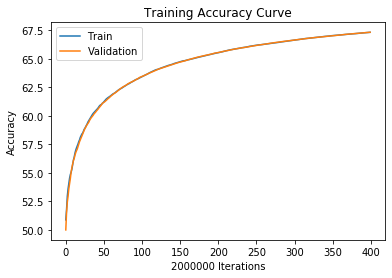

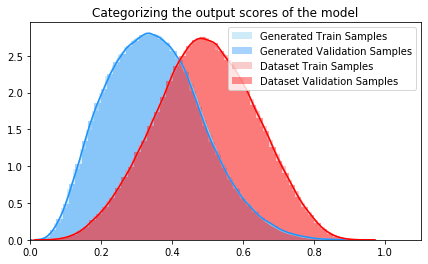

  7%|▋         | 35195/491198 [03:40<38:50, 195.69it/s]

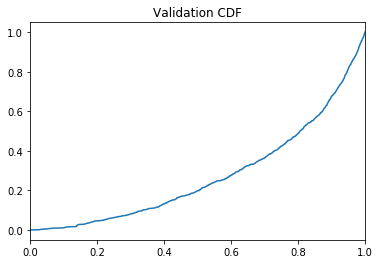

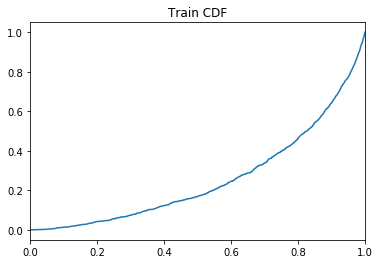

  7%|▋         | 35233/491198 [04:28<139:53:54,  1.10s/it]

Training AUC at epoch 4: 0.25612836363636365
Validation AUC epoch 4: 0.27351899999999996
Training Accuracy at epoch 4: 67.3324
Validation Accuracy epoch 4: 67.3402


 17%|█▋        | 85202/491198 [09:03<41:51, 161.63it/s]   

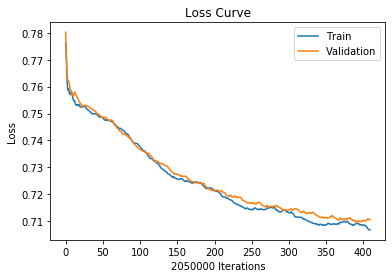

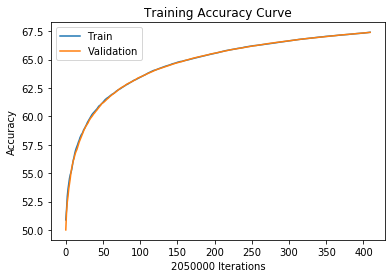

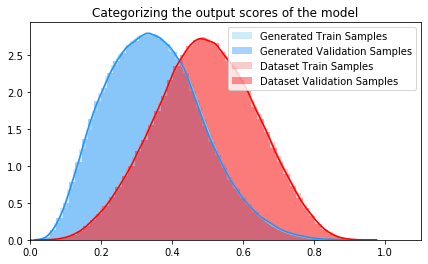

 17%|█▋        | 85202/491198 [09:20<41:51, 161.63it/s]

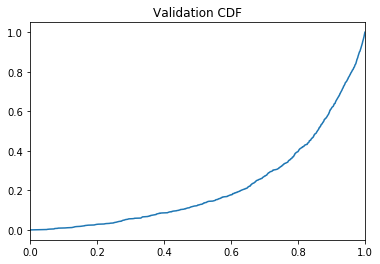

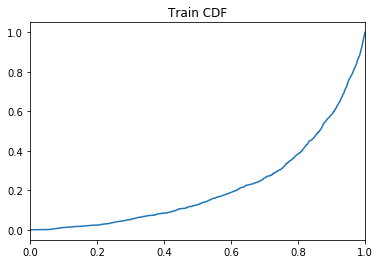

 17%|█▋        | 85229/491198 [10:11<270:31:20,  2.40s/it]

Training AUC at epoch 4: 0.21686654545454545
Validation AUC epoch 4: 0.22004
Training Accuracy at epoch 4: 67.41146341463414
Validation Accuracy epoch 4: 67.40004878048781


 28%|██▊       | 135183/491198 [14:54<38:17, 154.97it/s]  

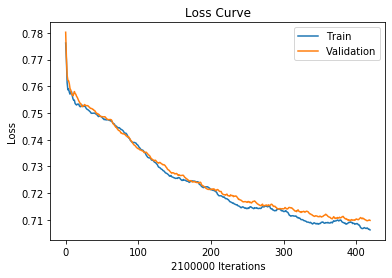

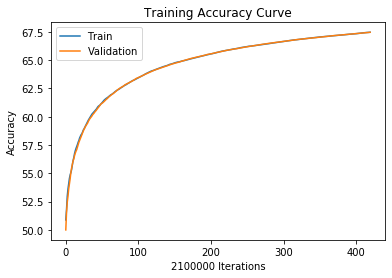

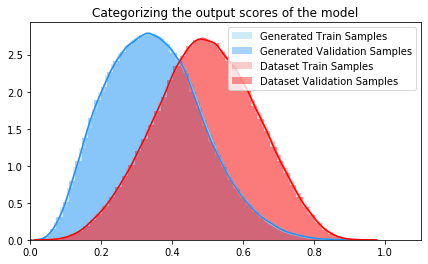

 28%|██▊       | 135183/491198 [15:10<38:17, 154.97it/s]

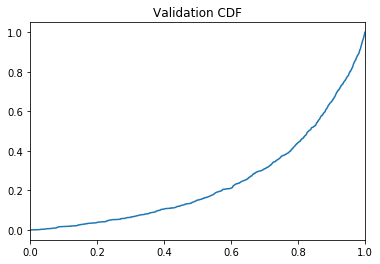

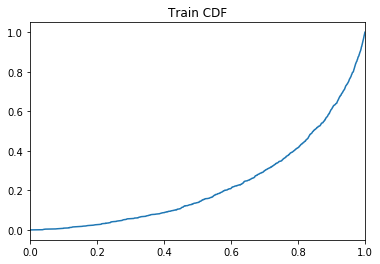

 28%|██▊       | 135232/491198 [16:04<57:46:59,  1.71it/s]

Training AUC at epoch 4: 0.22977327272727271
Validation AUC epoch 4: 0.24386263636363636
Training Accuracy at epoch 4: 67.46480952380952
Validation Accuracy epoch 4: 67.46038095238096


 38%|███▊      | 185204/491198 [20:45<28:43, 177.58it/s]  

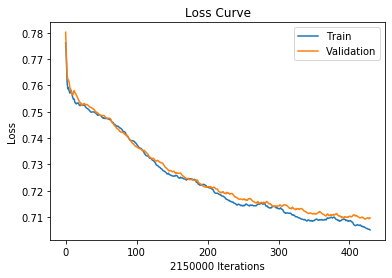

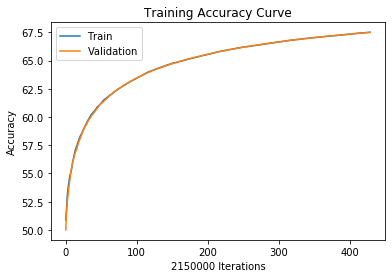

 38%|███▊      | 185204/491198 [21:01<28:43, 177.58it/s]

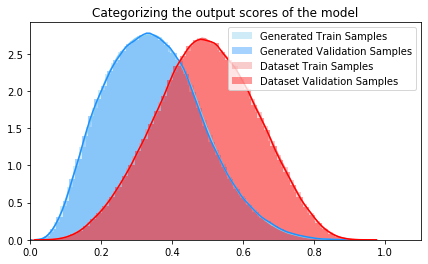

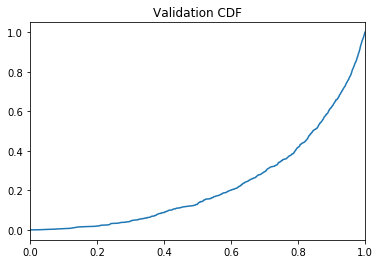

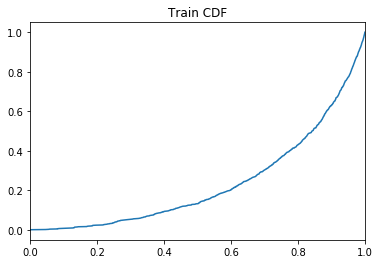

 38%|███▊      | 185224/491198 [21:54<307:14:04,  3.61s/it]

Training AUC at epoch 4: 0.23398881818181816
Validation AUC epoch 4: 0.227574
Training Accuracy at epoch 4: 67.51679069767442
Validation Accuracy epoch 4: 67.50693023255813


 48%|████▊     | 235198/491198 [26:35<22:44, 187.66it/s]   

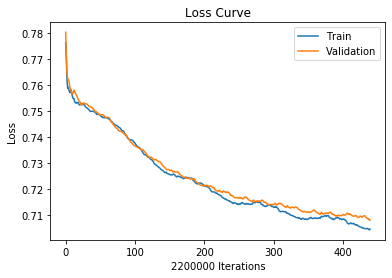

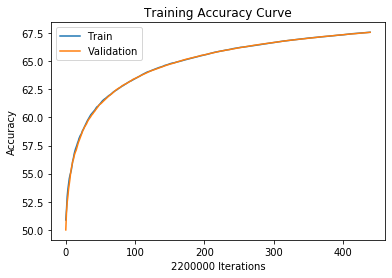

 48%|████▊     | 235198/491198 [26:51<22:44, 187.66it/s]

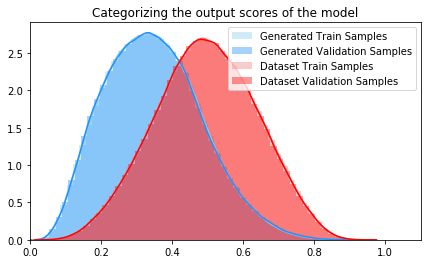

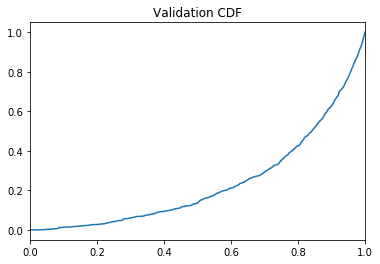

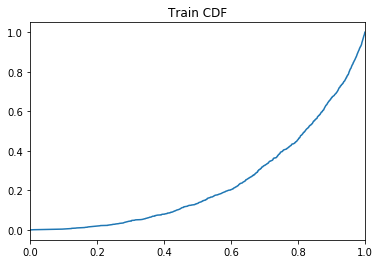

 48%|████▊     | 235233/491198 [27:44<103:13:21,  1.45s/it]

Training AUC at epoch 4: 0.23949118181818183
Validation AUC epoch 4: 0.23496163636363637
Training Accuracy at epoch 4: 67.567
Validation Accuracy epoch 4: 67.56054545454545


 58%|█████▊    | 285192/491198 [32:26<21:45, 157.82it/s]   

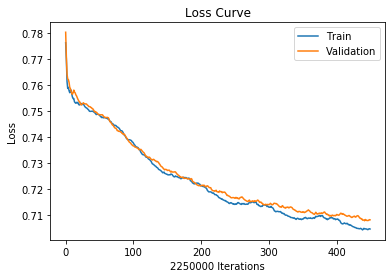

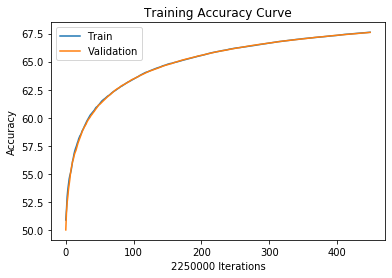

 58%|█████▊    | 285192/491198 [32:41<21:45, 157.82it/s]

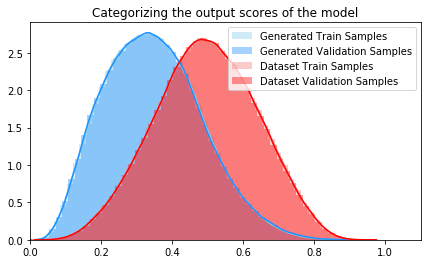

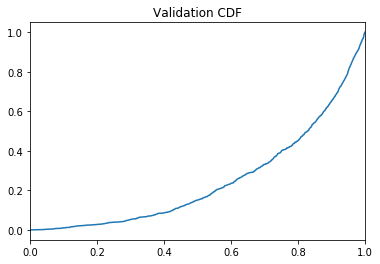

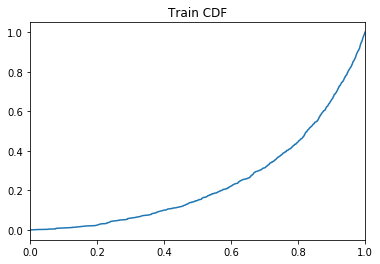

 58%|█████▊    | 285235/491198 [33:35<52:22:50,  1.09it/s]

Training AUC at epoch 4: 0.2448428181818182
Validation AUC epoch 4: 0.24717781818181817
Training Accuracy at epoch 4: 67.62022222222222
Validation Accuracy epoch 4: 67.60728888888889


 68%|██████▊   | 335202/491198 [38:17<14:17, 181.92it/s]  

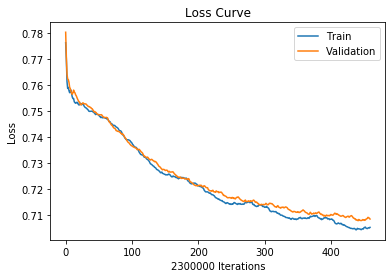

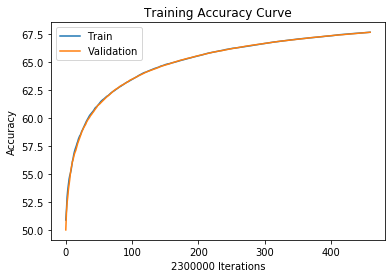

 68%|██████▊   | 335202/491198 [38:31<14:17, 181.92it/s]

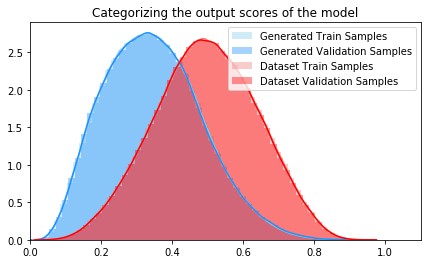

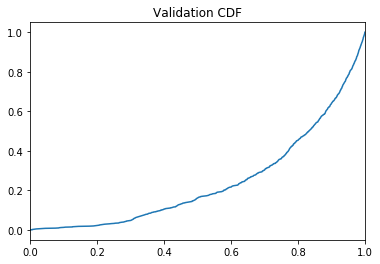

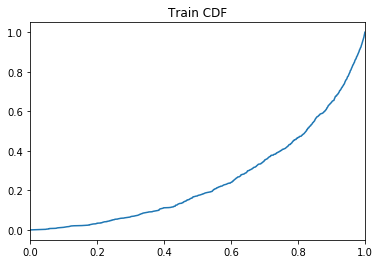

 68%|██████▊   | 335233/491198 [39:27<107:18:10,  2.48s/it]

Training AUC at epoch 4: 0.25538236363636363
Validation AUC epoch 4: 0.24118363636363638
Training Accuracy at epoch 4: 67.65569565217392
Validation Accuracy epoch 4: 67.65282608695652


 78%|███████▊  | 385203/491198 [44:00<09:56, 177.76it/s]   

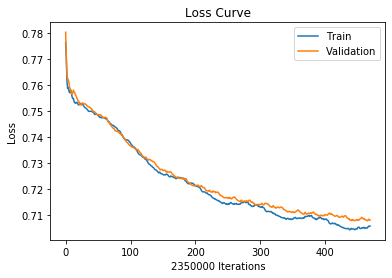

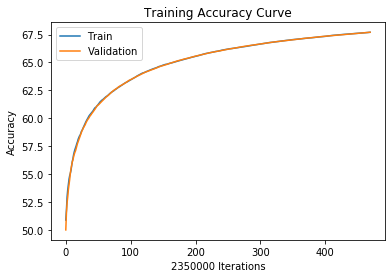

 78%|███████▊  | 385203/491198 [44:11<09:56, 177.76it/s]

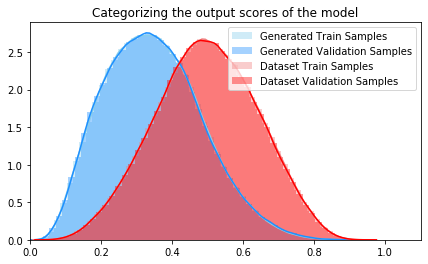

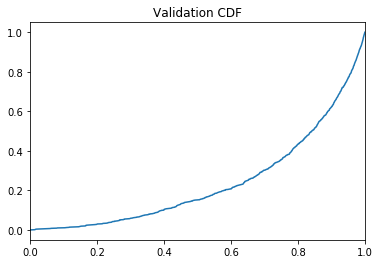

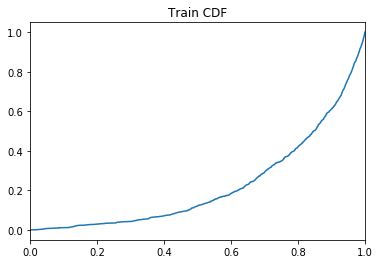

 78%|███████▊  | 385224/491198 [45:12<89:12:43,  3.03s/it] 

Training AUC at epoch 4: 0.22372599999999998
Validation AUC epoch 4: 0.23712945454545453
Training Accuracy at epoch 4: 67.702
Validation Accuracy epoch 4: 67.70689361702128


 89%|████████▊ | 435207/491198 [49:56<04:46, 195.70it/s]  

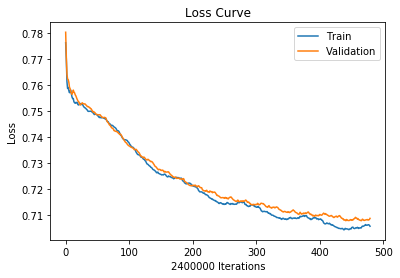

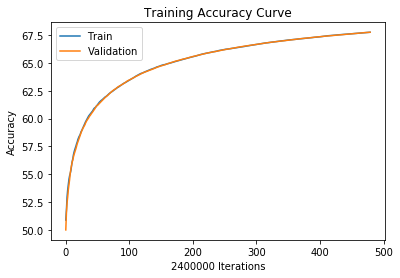

 89%|████████▊ | 435207/491198 [50:11<04:46, 195.70it/s]

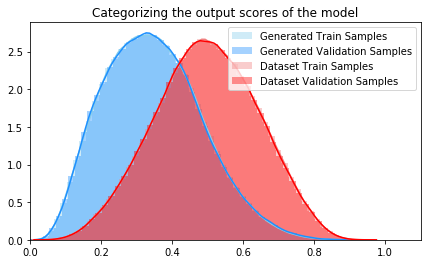

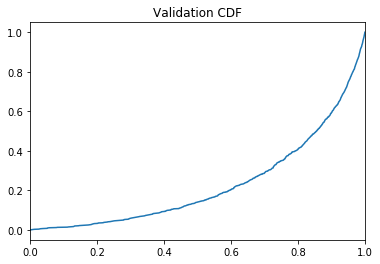

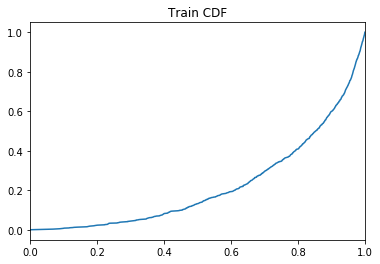

 89%|████████▊ | 435230/491198 [51:06<231:08:35, 14.87s/it]

Training AUC at epoch 4: 0.22287827272727273
Validation AUC epoch 4: 0.22851472727272726
Training Accuracy at epoch 4: 67.74758333333334
Validation Accuracy epoch 4: 67.74870833333334


 99%|█████████▉| 485200/491198 [55:50<00:37, 159.18it/s]   

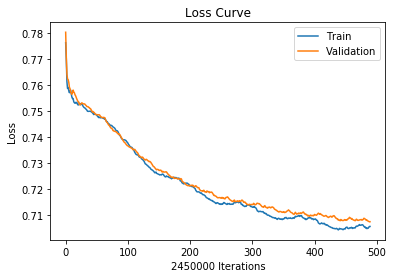

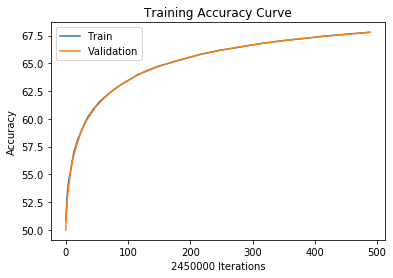

 99%|█████████▉| 485200/491198 [56:01<00:37, 159.18it/s]

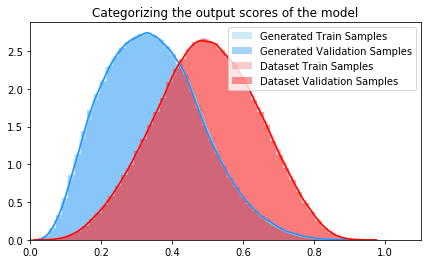

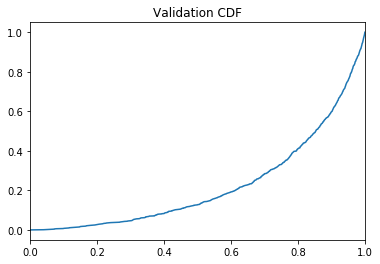

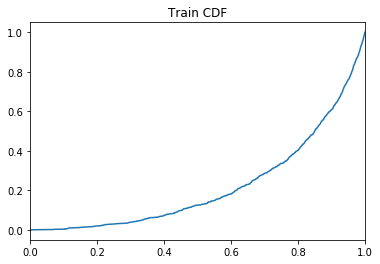

 99%|█████████▉| 485235/491198 [57:02<3:08:16,  1.89s/it]

Training AUC at epoch 4: 0.2199819090909091
Validation AUC epoch 4: 0.22296372727272726
Training Accuracy at epoch 4: 67.79118367346939
Validation Accuracy epoch 4: 67.79526530612245


  0%|          | 19/491198 [00:00<44:16, 184.91it/s]

Saving to:  model_checkpoints/binary/BlosumNet/07292020.pth
Starting epoch: 5  with learning rate:  [0.008100000000000001]


  9%|▉         | 43990/491198 [04:08<46:35, 159.99it/s]

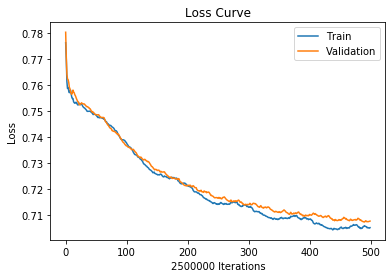

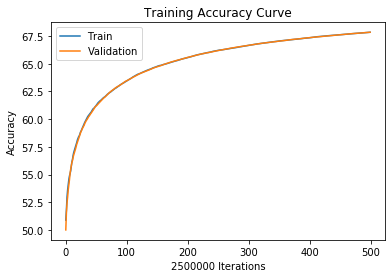

 19%|█▉        | 93998/491198 [10:03<37:34, 176.22it/s]

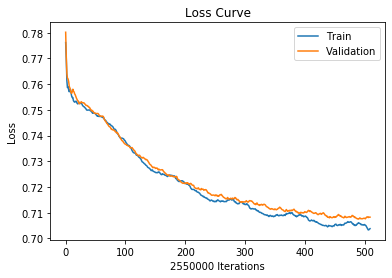

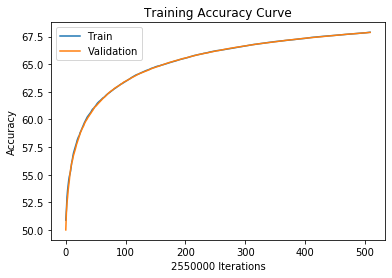

 19%|█▉        | 93998/491198 [10:20<37:34, 176.22it/s]

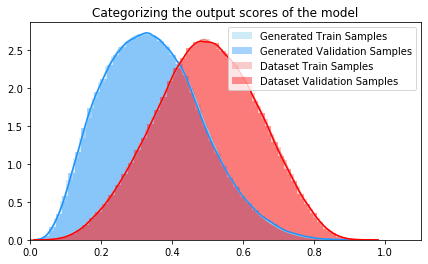

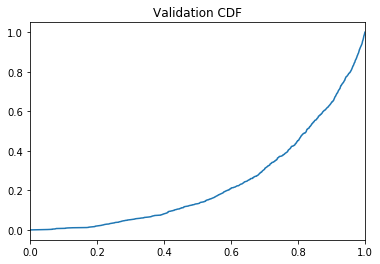

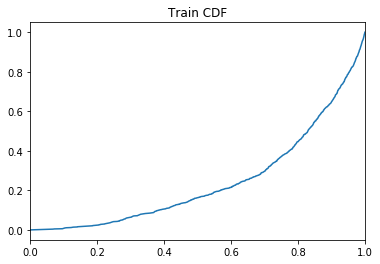

 19%|█▉        | 94026/491198 [11:16<140:47:51,  1.28s/it]

Training AUC at epoch 5: 0.24380290909090907
Validation AUC epoch 5: 0.23670045454545452
Training Accuracy at epoch 5: 67.89486274509804
Validation Accuracy epoch 5: 67.87898039215686


 29%|██▉       | 143999/491198 [15:57<30:25, 190.23it/s]  

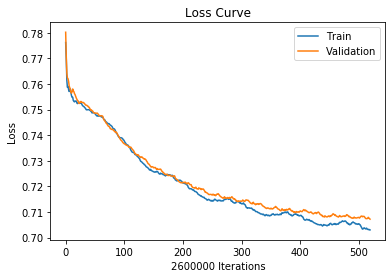

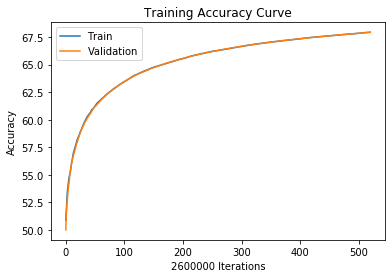

 29%|██▉       | 143999/491198 [16:10<30:25, 190.23it/s]

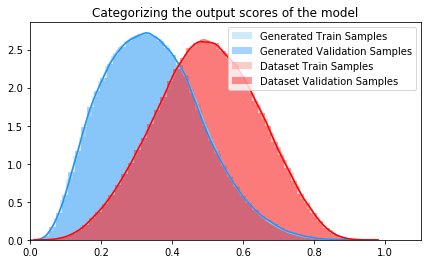

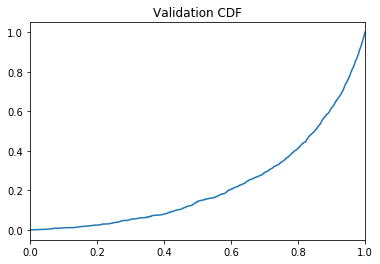

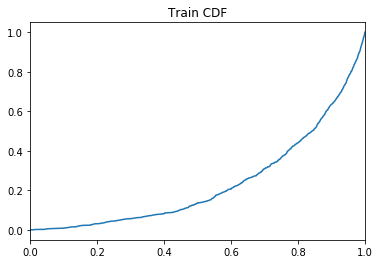

 29%|██▉       | 144034/491198 [17:09<132:21:22,  1.37s/it]

Training AUC at epoch 5: 0.2346063636363636
Validation AUC epoch 5: 0.22774354545454545
Training Accuracy at epoch 5: 67.93373076923076
Validation Accuracy epoch 5: 67.92519230769231


 39%|███▉      | 194002/491198 [21:35<30:35, 161.90it/s]   

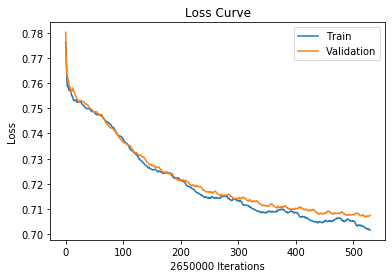

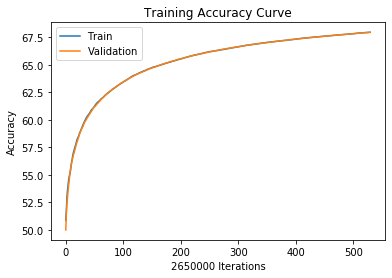

 39%|███▉      | 194002/491198 [21:50<30:35, 161.90it/s]

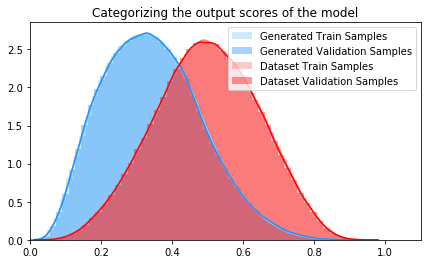

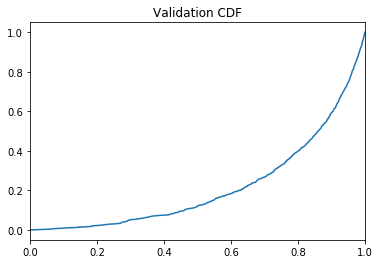

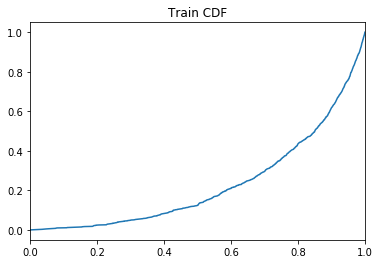

 40%|███▉      | 194034/491198 [22:47<156:31:52,  1.90s/it]

Training AUC at epoch 5: 0.22906872727272728
Validation AUC epoch 5: 0.21636772727272727
Training Accuracy at epoch 5: 67.97169811320755
Validation Accuracy epoch 5: 67.95841509433963


 50%|████▉     | 244004/491198 [27:23<23:30, 175.21it/s]   

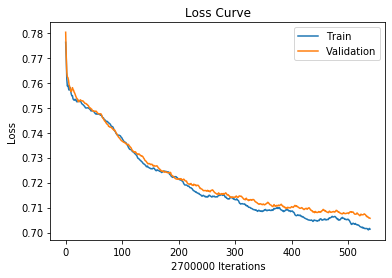

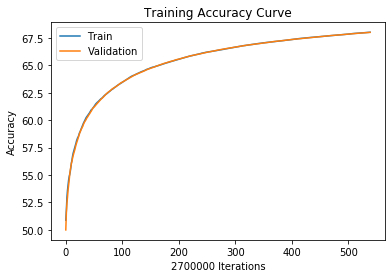

 50%|████▉     | 244004/491198 [27:40<23:30, 175.21it/s]

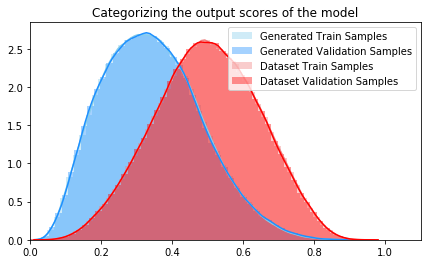

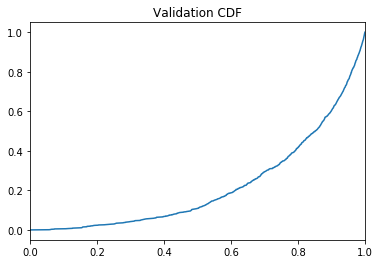

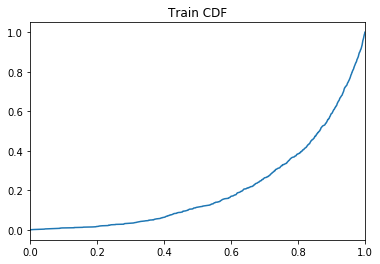

 50%|████▉     | 244034/491198 [28:35<173:06:15,  2.52s/it]

Training AUC at epoch 5: 0.20917645454545455
Validation AUC epoch 5: 0.21961490909090908
Training Accuracy at epoch 5: 68.01325925925926
Validation Accuracy epoch 5: 68.00277777777778


 60%|█████▉    | 294007/491198 [33:16<18:08, 181.14it/s]   

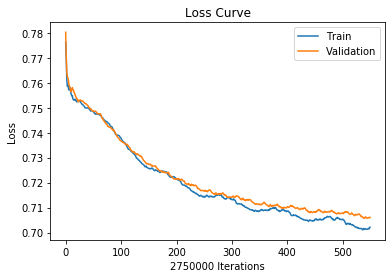

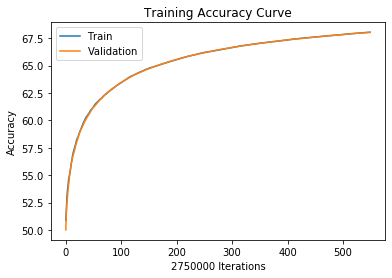

 60%|█████▉    | 294007/491198 [33:30<18:08, 181.14it/s]

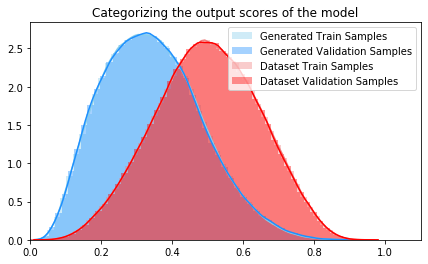

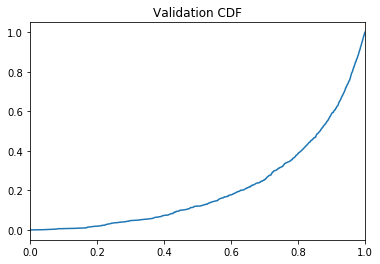

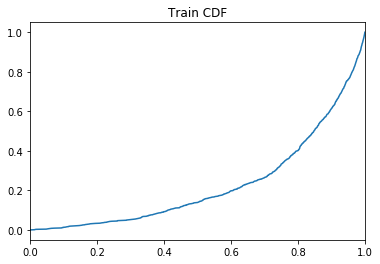

 60%|█████▉    | 294026/491198 [34:29<281:44:41,  5.14s/it]

Training AUC at epoch 5: 0.22728509090909094
Validation AUC epoch 5: 0.21165454545454546
Training Accuracy at epoch 5: 68.04836363636363
Validation Accuracy epoch 5: 68.03654545454546


 70%|███████   | 344000/491198 [39:09<12:31, 195.80it/s]   

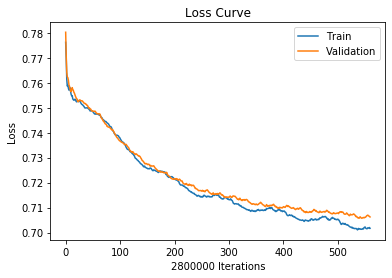

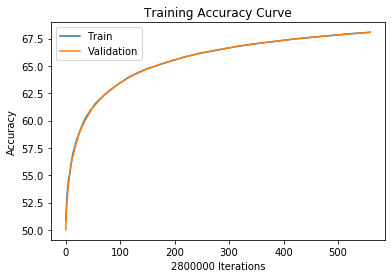

 70%|███████   | 344000/491198 [39:20<12:31, 195.80it/s]

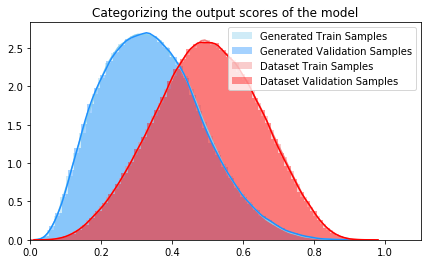

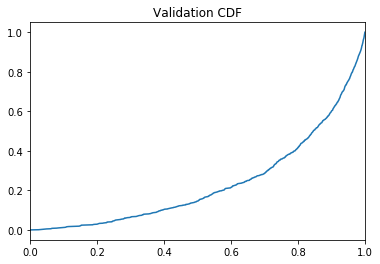

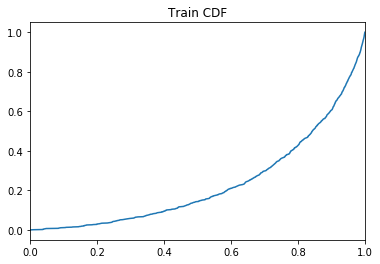

 70%|███████   | 344031/491198 [40:27<67:47:35,  1.66s/it]

Training AUC at epoch 5: 0.2327218181818182
Validation AUC epoch 5: 0.2337576363636364
Training Accuracy at epoch 5: 68.08407142857143
Validation Accuracy epoch 5: 68.07210714285715


 80%|████████  | 393992/491198 [45:08<08:18, 195.03it/s]  

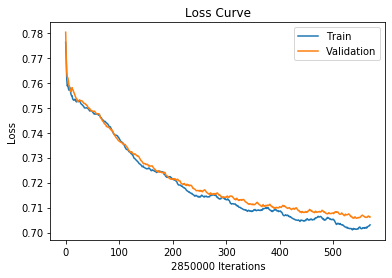

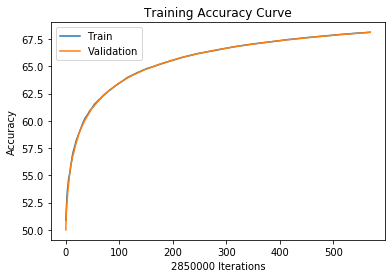

 80%|████████  | 393992/491198 [45:20<08:18, 195.03it/s]

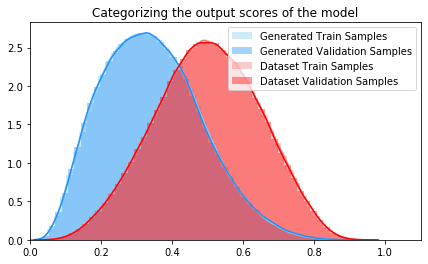

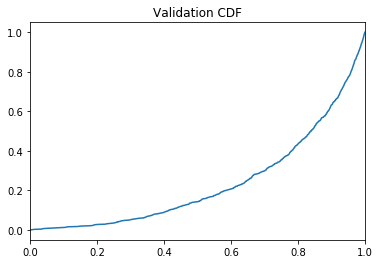

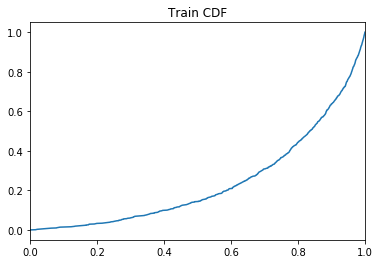

 80%|████████  | 394034/491198 [46:21<23:08:18,  1.17it/s]

Training AUC at epoch 5: 0.23831527272727274
Validation AUC epoch 5: 0.23504090909090913
Training Accuracy at epoch 5: 68.11943859649122
Validation Accuracy epoch 5: 68.11242105263157


 90%|█████████ | 443991/491198 [50:59<04:15, 184.84it/s]  

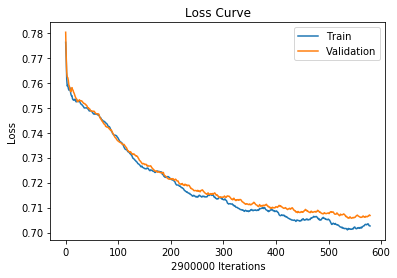

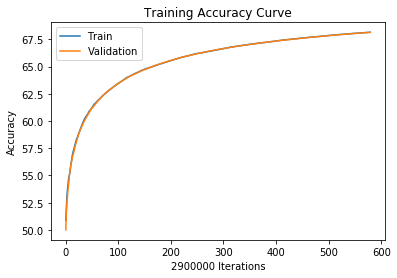

 90%|█████████ | 443991/491198 [51:10<04:15, 184.84it/s]

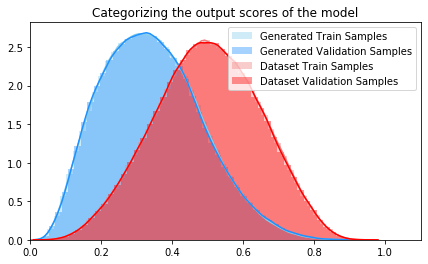

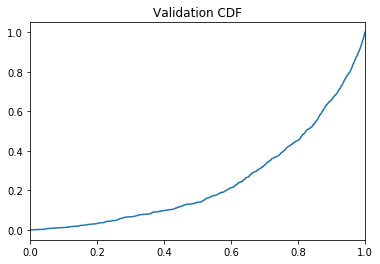

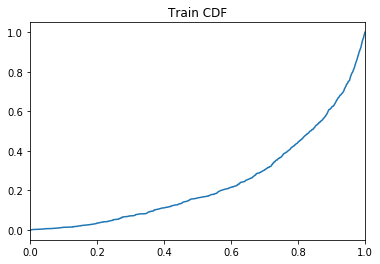

 90%|█████████ | 444034/491198 [52:12<10:39:24,  1.23it/s]

Training AUC at epoch 5: 0.24124490909090907
Validation AUC epoch 5: 0.24621272727272728
Training Accuracy at epoch 5: 68.15365517241379
Validation Accuracy epoch 5: 68.14175862068966


 92%|█████████▏| 449559/491198 [52:43<04:35, 151.36it/s]  

In [ ]:
model = BlosumNet()
model_name = model.name
model_id = "07292020"
model.to(device)
checkpoint = 'model_checkpoints/binary/%s/%s.pth' % (model_name, model_id)
save_path = 'model_checkpoints/binary/%s/%s.pth' % (model_name, model_id)
NUM_EPOCHS = 50
BATCH_SIZE = 64
cdf=False
if cdf:
   # For the CDF functions, we need to generate a dataset of new examples
    S_new = GeneratedDataset(10*m) 
gamma = 1e-3
classifier(model, binary_train, binary_val, gamma, model_id, NUM_EPOCHS, BATCH_SIZE, model.single_alphabet, checkpoint, save_path, cdf=cdf)

## Evaluate the model